# Laminar model comparison using cross-validation error

This tutorial demonstrates how to perform laminar inference using model comparison based on cross-validation error as a metric of model fit, described in [Bonaiuto et al., 2018, Non-invasive laminar inference with MEG: Comparison of methods and source inversion algorithms](https://doi.org/10.1016/j.neuroimage.2017.11.068). A 20Hz oscillation is simulated at a particular cortical location in various layers. Source reconstruction is performed using the Empirical Bayesian Beamformer on the simulated sensor data using forward models based on different layer meshes. These models are then compared using cross-validation error. Cross-validation error is computed by fitting the model N times, each time leaving out a certain percentage of the channels and seeing how well the resulting model can predict the signal in those channels

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison
from lameg.util import get_surface_names, get_fiducial_coords
from lameg.viz import show_surface
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas, lpa, rpa = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id,
    'meg',
    ses_id, 
    'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri', 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_data', subj_id, 'surf'), 
    'link_vector.fixed'
)

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/model_comp_cverr'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
06-Aug-2024 17:37:30 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 17:37:30 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           17:37:31 - 06/08/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiome

## Simulating a signal on the pial surface
We're going to simulate 1s of a 20Hz sine wave with a dipole moment of 10nAm

Text(0, 0.5, 'Amplitude (nAm)')

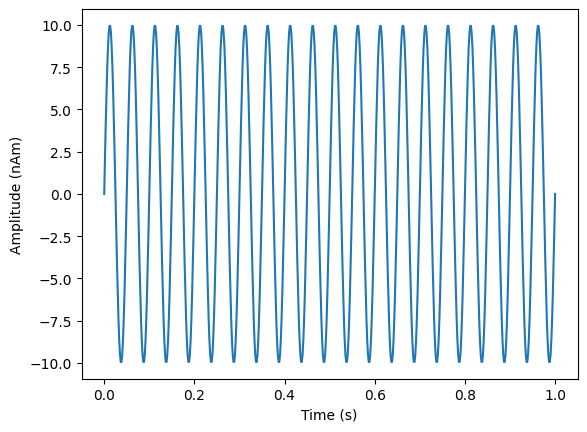

In [5]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 600

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,1,s_rate+1)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

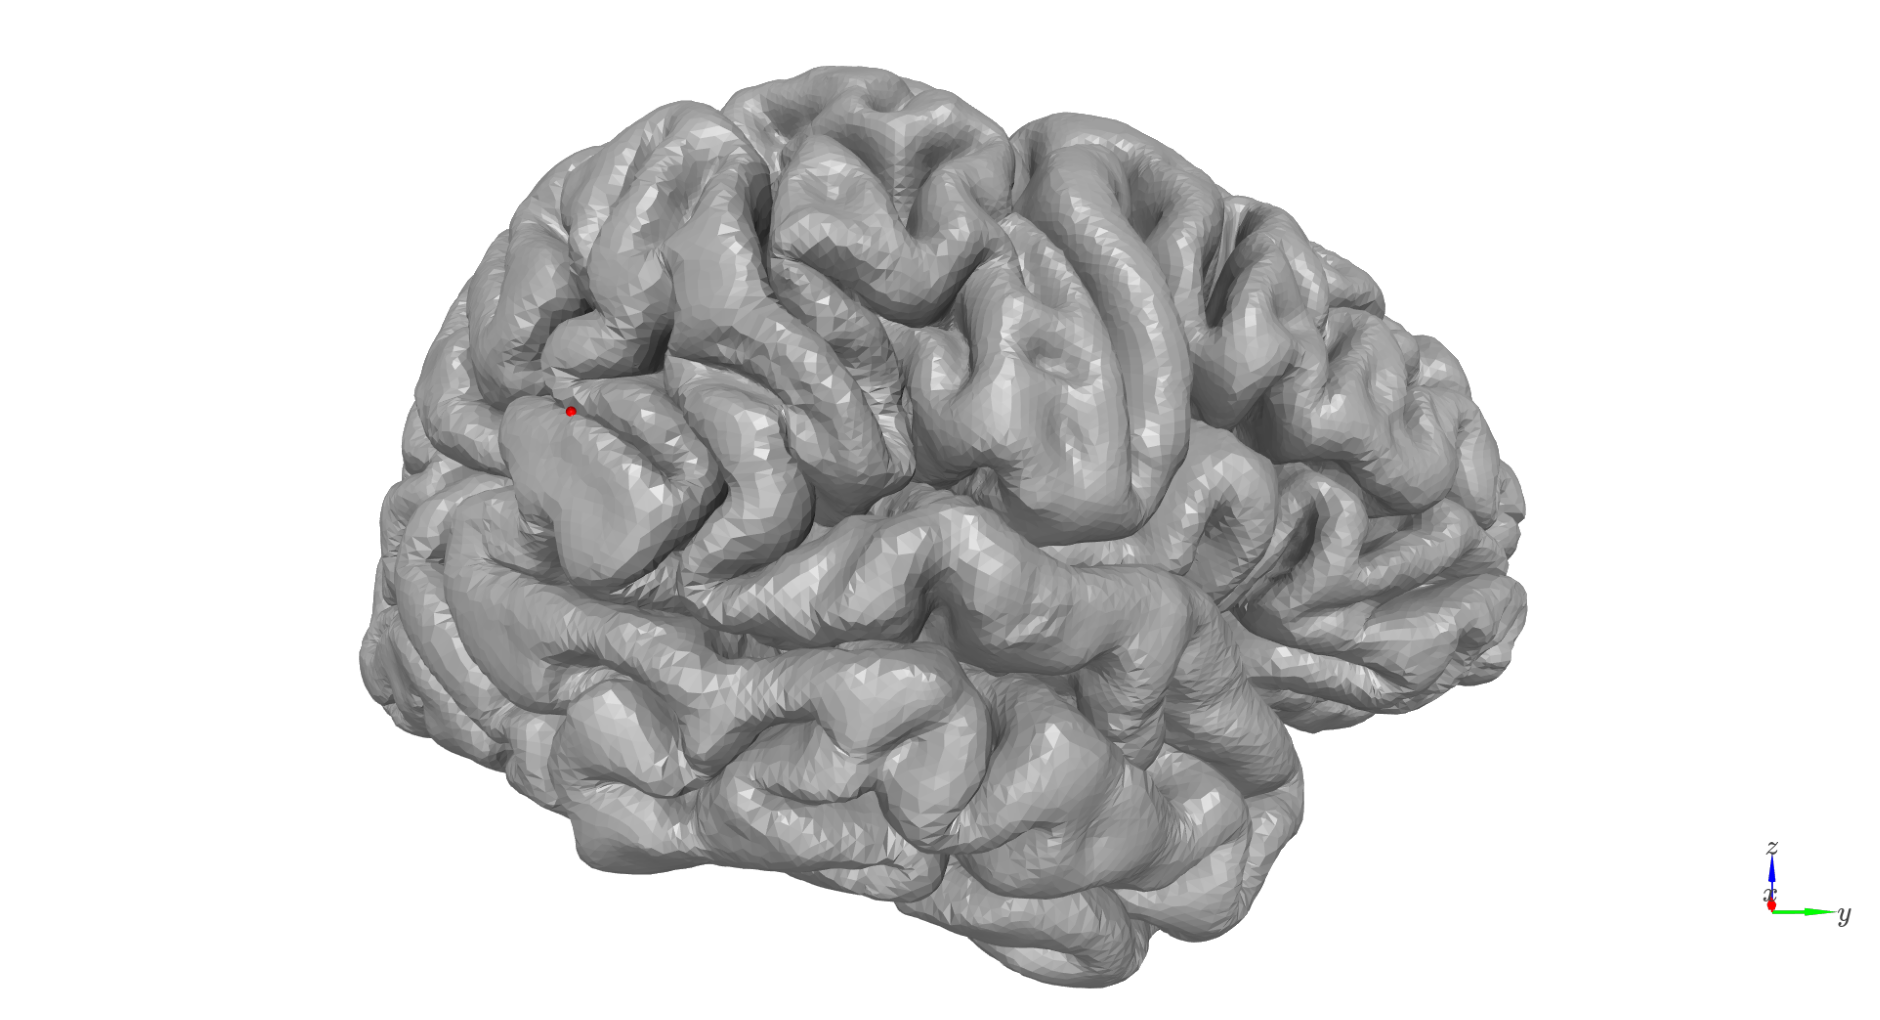

In [7]:
# Vertex to simulate activity at
sim_vertex=24585

pial_ds_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [7]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -5

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
)   

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 655.24 pAm/mm2, peak momemnt density 1216.78 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 655.24, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1216.78, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_pial_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior777361.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 

## Model comparison (pial - white matter)
Now we can run model comparison between source models based on the pial and white matter surfaces using cross-validation error. For computing cross-validation error, we'll run 10 folds, leaving out 10% of the channels in each fold. We'll then look at the difference in cross-validation error between the two models (pial - white matter). This should be lower for the pial surface model because we simulated activity on the pial surface

In [8]:
# Number of cross validation folds
n_folds = 10
# Percentage of test channels in cross validation
ideal_pc_test = 10 # may not use this number as we need integer number of channels

# Run model comparison between the first layer (pial) and the last layer (white matter)
[_,cvErr] = model_comparison(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    pial_sim_fname, 
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes, 
        'n_folds': n_folds, 
        'ideal_pc_test': ideal_pc_test    
    }
)
    
# The difference in cross validation error after averaging over test channels and folds
# This value should be negative (less error for the pial layer model)
np.mean(np.mean(cvErr[0],axis=-1),axis=-1)-np.mean(np.mean(cvErr[1],axis=-1),axis=-1)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 09:59:29 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 09:59:29 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           09:59:46 - 22/07/2024
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 sy

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.35 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.891421e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787781e+04 [+4.25]
  ReML Iteration 3                      :        ...2.562137e+04 [+4.38]
  ReML Iteration 4                      :        ...2.098964e+04 [+4.50]
  ReML Iteration 5                      :        ...4.622927e+02 [+4.62]
  ReML Iteration 6                      :        ...6.445714e+00 [+4.75]
  ReML Iteration 7                      :        ...1.598815e-01 [+4.88]
  ReML Iteration 8                      :        ...5.894078e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.891421e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787781e+04 [+4.25]
  ReML 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.892943e+04 [+4.12]
  ReML Iteration 2                      :        ...2.793265e+04 [+4.25]
  ReML Iteration 3                      :        ...2.575375e+04 [+4.38]
  ReML Iteration 4                      :        ...2.123705e+04 [+4.50]
  ReML Iteration 5                      :        ...3.930927e+02 [+4.62]
  ReML Iteration 6                      :        ...4.801767e+00 [+4.75]
  ReML Iteration 7                      :        ...9.915332e-02 [+4.88]
  ReML Iteration 8                      :        ...2.991867e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.892943e+04 [+4.12]
  ReML Iteration 2                      :        ...2.793265e+04 [+4.25]
  ReML Iteration 3                      :        ...2.575375e+04 [+4.38]
  ReML Iteration 4                      :        ...2.123705e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.892910e+04 [+4.12]
  ReML Iteration 2                      :        ...2.791457e+04 [+4.25]
  ReML Iteration 3                      :        ...2.576228e+04 [+4.38]
  ReML Iteration 4                      :        ...2.144526e+04 [+4.50]
  ReML Iteration 5                      :        ...6.319432e+02 [+4.62]
  ReML Iteration 6                      :        ...5.286860e+00 [+4.75]
  ReML Iteration 7                      :        ...2.468731e-01 [+4.88]
  ReML Iteration 8                      :        ...1.484043e-02 [+5.00]
  ReML Iteration 9                      :        ...8.470295e-04 [+5.12]
Percent variance explained 99.98 (58.99)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
     

Percent variance explained 99.98 (57.30)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -2.8542e+05
           ID: 542.6285
           R2: 99.9844
           VE: 57.29

Percent variance explained 99.99 (59.25)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -2.8578e+05
           ID: 578.6897
           R2: 99.9861
           VE: 59.24

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -3.0037e+05
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -3.0037e+05
           ID: 554.2149
           R2: 99.967


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.724153e+04 [+4.12]
  ReML Iteration 2                      :        ...2.533591e+04 [+4.25]
  ReML Iteration 3                      :        ...2.247714e+04 [+4.38]
  ReML Iteration 4                      :        ...1.761363e+04 [+4.50]
  ReML Iteration 5                 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.737301e+04 [+4.12]
  ReML Iteration 2                      :        ...2.561523e+04 [+4.25]
  ReML Iteration 3                      :        ...2.298859e+04 [+4.38]
  ReML Iteration 4                      :        ...1.849542e+04 [+4.50]
  ReML Iteration 5                      :        ...5.429434e+01 [+4.62]
  ReML Iteration 6                      :        ...3.440064e-02 [+4.75]
  ReML Iteration 7                      :        ...2.182097e-05 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.737301e+04 [+4.12]
  ReML Iteration 2                      :        ...2.561523e+04 [+4.25]
  ReML Iteration 3                      :        ...2.298859e+04 [+4.38]
  ReML Iteration 4                      :        ...1.849542e+04 [+4.50]
  ReML Iteration 5                      :        ...5.429434e+01 [+4.62]
  ReML Iteration 6               

Percent variance explained 99.97 (58.64)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -3.0230e+05
           ID: 563.4539
           R2: 99.9653
           VE: 58.63

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -3.0105e+05
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -3.0105e+05
           ID: 574.9872
           R2: 99.964

-2.9052589777810205

## White matter surface simulation with pial - white matter model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, model comparison should yield lower cross-validation error for the white matter surface.

In [9]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

# Run model comparison between the first layer (pial) and the last layer (white matter)
[_,cvErr] = model_comparison(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    white_sim_fname, 
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': n_temp_modes, 
        'n_folds': n_folds, 
        'ideal_pc_test': ideal_pc_test    
    }
)

# The difference in cross validation error after averaging over test channels and folds
# This value should be positive (less error for the white matter layer model)
np.mean(np.mean(cvErr[0],axis=-1),axis=-1)-np.mean(np.mean(cvErr[1],axis=-1),axis=-1)

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 522.28 pAm/mm2, peak momemnt density 1293.99 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 522.28, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1293.99, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_white_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior182056.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble



 Cross val iteration 1 of 10, first two chans:222, 214..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.801649e+04 [+4.12]
  ReML Iteration 2                      :        ...2.643161e+04 [+4.25]
  ReML Iteration 3                      :        ...2.376694e+04 [+4.38]
  ReML Iteration 4                      :        ...1.883742e+04 [+4.50]
  ReML Iteration 5                 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.91 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.791074e+04 [+4.12]
  ReML Iteration 2                      :        ...2.628517e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353775e+04 [+4.38]
  ReML Iteration 4                      :        ...1.844592e+04 [+4.50]
  ReML Iteration 5                      :        ...4.125038e+02 [+4.62]
  ReML Iteration 6                      :        ...2.475385e+00 [+4.75]
  ReML Iteration 7                      :        ...2.015121e-02 [+4.88]
  ReML Iteration 8                      :        ...2.153176e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.791074e+04 [+4.12]
  ReML Iteration 2                      :        ...2.628517e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.796933e+04 [+4.12]
  ReML Iteration 2                      :        ...2.645328e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395409e+04 [+4.38]
  ReML Iteration 4                      :        ...1.930227e+04 [+4.50]
  ReML Iteration 5                      :        ...5.444786e+02 [+4.62]
  ReML Iteration 6                      :        ...1.932993e+00 [+4.75]
  ReML Iteration 7                      :        ...3.727733e-02 [+4.88]
  ReML Iteration 8                      :        ...8.469890e-04 [+5.00]
Percent variance explained 99.98 (56.14)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip:

Percent variance explained 99.98 (55.75)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -2.8501e+05
           ID: 438.2361
           R2: 99.9815
           VE: 55.75

model evidences relative to maximum:

ans =

     0

       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: -2.8211e+05
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip: [1x512 double]
            M: [49733x247 double]
            J: {[49733x4 double]}
            Y: [247x4 double]
            L: [247x49733 double]
           qC: [49733x1 double]
        tempU: [513x513 double]
            V: [513x4 double]
           qV: [601x601 double]
            T: [601x4 double]
            U: {[247x247 double]}
           Is: [1x49733 double]
           It: [1x601 double]
           Ik: [1x60 double]
           Ic: {[1x247 double]}
           Nd: 49733
          pst: [1x601 double]
          dct: [1x513 double]
            F: -2.8211e+05
           ID: 430.8618
           R2: 99.982


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.36 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.882721e+04 [+4.12]
  ReML Iteration 2                      :        ...2.767827e+04 [+4.25]
  ReML Iteration 3                      :        ...2.529660e+04 [+4.38]
  ReML Iteration 4                      :        ...2.065693e+04 [+4.50]
  ReML Iteration 5                

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.76 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.891445e+04 [+4.12]
  ReML Iteration 2                      :        ...2.786988e+04 [+4.25]
  ReML Iteration 3                      :        ...2.559187e+04 [+4.38]
  ReML Iteration 4                      :        ...2.091499e+04 [+4.50]
  ReML Iteration 5                      :        ...5.332936e+02 [+4.62]
  ReML Iteration 6                      :        ...7.469891e+00 [+4.75]
  ReML Iteration 7                      :        ...2.772953e-01 [+4.8

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.55 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.883670e+04 [+4.12]
  ReML Iteration 2                      :        ...2.770277e+04 [+4.25]
  ReML Iteration 3                      :        ...2.534605e+04 [+4.38]
  ReML Iteration 4                      :        ...2.072831e+04 [+4.50]
  ReML Iteration 5                      :        ...6.130862e+02 [+4.62]
  ReML Iteration 6                      :        ...4.674077e+00 [+4.75]
  ReML Iteration 7                      :        ...1.859069e-01 [+4.88]
  ReML Iteration 8                      :        ...9.403431e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.883670e+04 [+4.12]
  ReML Iteration 2                      :        ...2.770277e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.877176e+04 [+4.12]
  ReML Iteration 2                      :        ...2.758259e+04 [+4.25]
  ReML Iteration 3                      :        ...2.518666e+04 [+4.38]
  ReML Iteration 4                      :        ...2.057020e+04 [+4.50]
  ReML Iteration 5                      :        ...6.010571e+02 [+4.62]
  ReML Iteration 6                      :        ...4.485381e+00 [+4.75]
  ReML Iteration 7                      :        ...1.487402e-01 [+4.88]
  ReML Iteration 8                      :        ...6.290959e-03 [+5.00]
Percent variance explained 99.99 (56.68)
       priors: []
         type: 'EBB'
          woi: [-500 500]
          Han: 0
          lpf: 0
          hpf: 256
    mergeflag: 0
           Np: 512
           Nm: 247
           Nt: 4
       smooth: 5
     modality: 'MEG'
         allF: 0
      PostMax: [49733x1 double]
            A: [247x247 double]
           Ip:

1.1529758274587714

## Simulation in each layer with model comparison across layers
That was model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run model comparison across all layers. We'll turn off SPM visualization here.

In [9]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
all_layerCvErr = []

for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = l*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}_{l}_'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR,
        spm_instance=spm
    ) 

    [_,layerCvErr] = model_comparison(
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        layer_fnames, 
        l_sim_fname, 
        viz=False,
        spm_instance=spm,
        invert_kwargs={
            'patch_size': patch_size, 
            'n_temp_modes': n_temp_modes, 
            'n_folds': n_folds, 
            'ideal_pc_test': ideal_pc_test    
        }
    )
    all_layerCvErr.append(layerCvErr)    
all_layerCvErr = np.array(all_layerCvErr)

# Average over test channels and folds
all_layerCvErr = np.mean(np.mean(all_layerCvErr, axis=-1), axis=-1)

Simulating in layer 0
IdleTimeout has been reached.
Parallel pool using the 'local' profile is shutting down.
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 655.24 pAm/mm2, peak momemnt density 1216.78 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 655.24, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1216.78, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo/prior7773

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.891421e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787781e+04 [+4.25]
  ReML Iteration 3                      :        ...2.562137e+04 [+4.38]
  ReML Iteration 4                      :        ...2.098964e+04 [+4.50]
  ReML Iteration 5                      :        ...4.622927e+02 [+4.62]
  ReML Iteration 6                      :        ...6.445714e+00 [+4.75]
  ReML Iteration 7                      :        ...1.598815e-01 [+4.88]
  ReML Iteration 8                      :        ...5.894078e-03 [+5.00]
Percent variance explained 99.98 (56.34)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:1, 136..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoot

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.892910e+04 [+4.12]
  ReML Iteration 2                      :        ...2.791457e+04 [+4.25]
  ReML Iteration 3                      :        ...2.576228e+04 [+4.38]
  ReML Iteration 4                      :        ...2.144526e+04 [+4.50]
  ReML Iteration 5                      :        ...6.319432e+02 [+4.62]
  ReML Iteration 6                      :        ...5.286860e+00 [+4.75]
  ReML Iteration 7                      :        ...2.468731e-01 [+4.88]
  ReML Iteration 8                      :        ...1.484043e-02 [+5.00]
  ReML Iteration 9                      :        ...8.470295e-04 [+5.12]
Percent variance explained 99.98 (58.99)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:221, 78..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfie

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.894712e+04 [+4.12]
  ReML Iteration 2                      :        ...2.795602e+04 [+4.25]
  ReML Iteration 3                      :        ...2.584261e+04 [+4.38]
  ReML Iteration 4                      :        ...2.157440e+04 [+4.50]
  ReML Iteration 5                      :        ...6.837546e+02 [+4.62]
  ReML Iteration 6                      :        ...5.240523e+00 [+4.75]
  ReML Iteration 7                      :        ...3.160298e-01 [+4.88]
  ReML Iteration 8                      :        ...2.398297e-02 [+5.00]
  ReML Iteration 9                      :        ...1.724537e-03 [+5.12]
Percent variance explained 99.99 (59.25)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:82, 41..
Running cross val..06-Aug-2024 18:30:22 - Done    'Source inversion, iterative'
06-Aug-2024 18:30:22 - Done

SPM, version dev (standalone)
M

Percent variance explained 99.99 (58.23)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.888443e+04 [+4.12]
  ReML Iteration 2                      :        ...2.783129e+04 [+4.25]
  ReML Iteration 3                      :        ...2.567922e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.94)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.879654e+04 [+4.12]
  ReML Iteration 2                      :        ...2.762086e+04 [+4.25]
  ReML Iteration 3                      :        ...2.522676e+04 [+4.38]
  ReML Iterat

  ReML Iteration 9                      :        ...6.113766e-04 [+5.12]
Percent variance explained 99.99 (58.65)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 18:34:10 - Done    'Source inversion, iterative'
06-Aug-2024 18:34:10 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 18:34:12 - Running job #1
------------------------------------------------------------------------

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.873533e+04 [+4.12]
  ReML Iteration 2                      :        ...2.755514e+04 [+4.25]
  ReML Iteration 3                      :        ...2.530159e+04 [+4.38]
  ReML Iteration 4                      :        ...2.107568e+04 [+4.50]
  ReML Iteration 5                      :        ...6.869316e+02 [+4.62]
  ReML Iteration 6                      :        ...2.202427e+00 [+4.75]
  ReML Iteration 7                      :        ...1.000892e-01 [+4.88]
  ReML Iteration 8                      :        ...5.227117e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.873533e+04 [+4.12]
  ReML Iteration 2                      :        ...2.755514e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.861179e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729144e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479962e+04 [+4.38]
  ReML Iteration 4                      :        ...2.017356e+04 [+4.50]
  ReML Iteration 5                      :        ...5.705169e+02 [+4.62]
  ReML Iteration 6                      :        ...2.741623e+00 [+4.75]
  ReML Iteration 7                      :        ...7.398373e-02 [+4.88]
  ReML Iteration 8                      :        ...2.413928e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.861179e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729144e+04 [+4.25]
  ReML 



------------------------------------------------------------------------
06-Aug-2024 18:37:39 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 18:37:39 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:38:04 - 06/08/2024
Completed                               :          18:38:05 - 06/08/2024
06-Aug-2024 18:38:06 - Done    'Head model specification'
06-Aug-2024 18:38:06 - Done

Smoothing ../test_data/sub-104/surf/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      18:38:06 - 06/08/2024
        ----------------

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.860521e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733185e+04 [+4.25]
  ReML Iteration 3                      :        ...2.501752e+04 [+4.38]
  ReML Iteration 4                      :        ...2.077044e+04 [+4.50]
  ReML Iteration 5                      :        ...5.812531e+02 [+4.62]
  ReML Iteration 6                      :        ...1.429058e+00 [+4.75]
  ReML Iteration 7                      :        ...4.675757e-02 [+4.88]
  ReML Iteration 8                      :        ...1.730622e-03 [+5.00]
Percent variance explained 99.98 (59.98)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.98 (56.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.831242e+04 [+4.12]
  ReML Iteration 2                      :        ...2.686505e+04 [+4.25]
  ReML Iteration 3                      :        ...2.442346e+04 [+4.38]
  ReML Iterat



------------------------------------------------------------------------
06-Aug-2024 18:42:17 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 18:42:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.20 percent average variance
NB smooth EBB algorithm !
Using 1

Percent variance explained 99.98 (54.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 60.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.805029e+04 [+4.12]
  ReML Iteration 2                      :        ...2.653581e+04 [+4.25]
  ReML Iteration 3                      :        ...2.416278e+04 [+4.38]
  ReML Iterat

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.804131e+04 [+4.12]
  ReML Iteration 2                      :        ...2.644880e+04 [+4.25]
  ReML Iteration 3                      :        ...2.383446e+04 [+4.38]
  ReML Iteration 4                      :        ...1.911732e+04 [+4.50]
  ReML Iteration 5                      :        ...3.295446e+02 [+4.62]
  ReML Iteration 6                      :        ...1.138644e+00 [+4.75]
  ReML Iteration 7                      :        ...9.080387e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.804131e+04 [+4.12]
  ReML Iteration 2                      :        ...2.644880e+04 [+4.25]
  ReML Iteration 3                      :        ...2.383446e+04 [+4.38]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.812287e+04 [+4.12]
  ReML Iteration 2                      :        ...2.654339e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395535e+04 [+4.38]
  ReML Iteration 4                      :        ...1.938679e+04 [+4.50]
  ReML Iteration 5                      :        ...2.871297e+02 [+4.62]
  ReML Iteration 6                      :        ...4.885861e-01 [+4.75]
  ReML Iteration 7                      :        ...4.513645e-03 [+4.88]
Percent variance explained 99.98 (57.19)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.lin

Percent variance explained 99.98 (60.06)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.783841e+04 [+4.12]
  ReML Iteration 2                      :        ...2.623313e+04 [+4.25]
  ReML Iteration 3                      :        ...2.371728e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.805798e+04 [+4.12]
  ReML Iteration 2                      :        ...2.650547e+04 [+4.25]
  ReML Iteration 3                      :        ...2.400335e+04 [+4.38]
  ReML Iteration 4                      :        ...1.956723e+04 [+4.50]
  ReML Iteration 5                      :        ...2.953473e+02 [+4.62]
  ReML Iteration 6                      :        ...4.553523e-01 [+4.75]
  ReML Iteration 7                      :        ...4.397944e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.805798e+04 [+4.12]
  ReML Iteration 2                      :        ...2.650547e+04 [+4.25]
  ReML Iteration 3                      :        ...2.400335e+04 [+4.38]
  ReML 

Percent variance explained 99.98 (58.22)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.823687e+04 [+4.12]
  ReML Iteration 2                      :        ...2.675103e+04 [+4.25]
  ReML Iteration 3                      :        ...2.431244e+04 [+4.38]
  ReML Iterat

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.791031e+04 [+4.12]
  ReML Iteration 2                      :        ...2.627258e+04 [+4.25]
  ReML Iteration 3                      :        ...2.367793e+04 [+4.38]
  ReML Iteration 4                      :        ...1.909011e+04 [+4.50]
  ReML Iteration 5                      :        ...2.868142e+02 [+4.62]
  ReML Iteration 6                      :        ...4.500049e-01 [+4.75]
  ReML Iteration 7                      :        ...4.062033e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.791031e+04 [+4.12]
  ReML Iteration 2                      :        ...2.627258e+04 [+4.25]
  ReML Iteration 3                      :        ...2.367793e+04 [+4.38]
  ReML 

Completed                               :          18:52:33 - 06/08/2024
06-Aug-2024 18:52:34 - Done    'Head model specification'
06-Aug-2024 18:52:34 - Done

Smoothing ../test_data/sub-104/surf/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      18:52:35 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training 

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.755334e+04 [+4.12]
  ReML Iteration 2                      :        ...2.575640e+04 [+4.25]
  ReML Iteration 3                      :        ...2.296338e+04 [+4.38]
  ReML Iteration 4                      :        ...1.808124e+04 [+4.50]
  ReML Iteration 5                      :        ...1.070314e+04 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.764342e+04 [+4.12]
  ReML Iteration 2                      :        ...2.595187e+04 [+4.25]
  ReML Iteration 3                      :        ...2.338588e+04 [+4.38]
  ReML Iteration 4                      :        ...1.896031e+04 [+4.50]
  ReML Iteration 5                      :        ...1.402522e+02 [+4.62]
  ReML Iteration 6                      :        ...9.124352e-02 [+4.75]
  ReML Iteration 7                      :        ...3.282132e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.764342e+04 [+4.12]
  ReML Iteration 2                      :        ...2.595187e+04 [+4.25]
  ReML Iteration 3                      :        ...2.338588e+04 [+4.38]
  ReML Iteration 4                      :        ...1.896031e+04 [+4.50]
  ReML Iteration 5                      :        ...1.402522e+02 [+4.62]
  ReML Iteration 6               



------------------------------------------------------------------------
06-Aug-2024 18:56:42 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 18:56:42 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_0_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.20 percent average variance
NB smooth EBB algorithm !
Using 1

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 60.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.741733e+04 [+4.12]
  ReML Iteration 2                      :        ...2.569597e+04 [+4.25]
  ReML Iteration 3                      :        ...2.321502e+04 [+4.38]
  ReML Iteration 4                      :        ...1.900133e+04 [+4.50]
  ReML Iteration 5                      :        ...1.137416e+02 [+4.62]
  ReML Iteration 6                      :        ...4.112112e-02 [+4.75]
  ReML Iteration 7                      :        ...1.285966e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.741733e+04 [+4.12]
  ReML Iteration 2                      :        ...2.569597e+04 [+4.25]
  ReML Iteration 3                      :        ...2.321502e+04 [+4.38]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.737315e+04 [+4.12]
  ReML Iteration 2                      :        ...2.558958e+04 [+4.25]
  ReML Iteration 3                      :        ...2.288954e+04 [+4.38]
  ReML Iteration 4                      :        ...1.818083e+04 [+4.50]
  ReML Iteration 5                      :        ...7.121404e+01 [+4.62]
  ReML Iteration 6                      :        ...1.349813e-01 [+4.75]
  ReML Iteration 7                      :        ...3.096829e-05 [+4.88]
Percent variance explained 99.97 (55.82)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.762545e+04 [+4.12]
  ReML Iteration 2                      :        ...2.588875e+04 [+4.25]
  ReML Iteration 3                      :        ...2.329458e+04 [+4.38]
  ReML Iteration 4                      :        ...1.886885e+04 [+4.50]
  ReML Iteration 5                      :        ...1.036524e+02 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.738471e+04 [+4.12]
  ReML Iteration 2                      :        ...2.564207e+04 [+4.25]
  ReML Iteration 3                      :        ...2.303215e+04 [+4.38]
  ReML Iteration 4                      :        ...1.854831e+04 [+4.50]
  ReML Iteration 5                      :        ...7.279234e+01 [+4.62]
  ReML Iteration 6                      :        ...4.610626e-02 [+4.75]
  ReML Iteration 7                      :        ...5.233302e-05 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.738471e+04 [+4.12]
  ReML Iteration 2                      :        ...2.564207e+04 [+4.25]
  ReML Iteration 3                      :        ...2.303215e+04 [+4.38]
  ReML Iteration 4                      :        ...1.854831e+04 [+4.50]
  ReML Iteration 5                      :        ...7.279234e+01 [+4.62]
  ReML Iteration 6               

Percent variance explained 99.97 (58.64)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 19:02:46 - Done    'Source inversion, iterative'
06-Aug-2024 19:02:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 19:02:48 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 19:02:48 - Running 'Head model specification'
white.ds.link_

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.781888e+04 [+4.12]
  ReML Iteration 2                      :        ...2.614679e+04 [+4.25]
  ReML Iteration 3                      :        ...2.359912e+04 [+4.38]
  ReML Iteration 4                      :        ...1.927712e+04 [+4.50]
  ReML Iteration 5                      :        ...8.756771e+01 [+4.62]
  ReML Iteration 6                      :        ...5.595016e-02 [+4.75]
  ReML Iteration 7                      :        ...1.007425e-04 [+4.88]
Percent variance explained 99.97 (59.97)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.727554e+04 [+4.12]
  ReML Iteration 2                      :        ...2.547672e+04 [+4.25]
  ReML Iteration 3                      :        ...2.283507e+04 [+4.38]
  ReML Iteration 4                      :        ...1.840225e+04 [+4.50]
  ReML Iteration 5                      :        ...2.741395e+01 [+4.62]
  ReML Iteration 6 

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      19:12:54 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 

Percent variance explained 99.99 (59.84)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:151, 227..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.42 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.864742e+04 [+4.12]
  ReML Iteration 2                      :        ...2.732214e+04 [+4.25]
  ReML Iteration 3                      :        ...2.471681e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (57.54)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:217, 195..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868023e+04 [+4.12]
  ReML Iteration 2                      :        ...2.742687e+04 [+4.25]
  ReML Iteration 3                      :        ...2.503125e+04 [+4.38]
  ReML Iterati


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_cverr/sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                      

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.876846e+04 [+4.12]
  ReML Iteration 2                      :        ...2.753061e+04 [+4.25]
  ReML Iteration 3                      :        ...2.495249e+04 [+4.38]
  ReML Iteration 4                      :        ...1.995817e+04 [+4.50]
  ReML Iteration 5                      :        ...1.199707e+04 [+4.62]
  ReML Iteration 6 

Percent variance explained 99.99 (56.42)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.888436e+04 [+4.12]
  ReML Iteration 2                      :        ...2.780930e+04 [+4.25]
  ReML Iteration 3                      :        ...2.555826e+04 [+4.38]
  ReML Iterat


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_cverr/sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                      

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.870061e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740419e+04 [+4.25]
  ReML Iteration 3                      :        ...2.478225e+04 [+4.38]
  ReML Iteration 4                      :        ...1.978319e+04 [+4.50]
  ReML Iteration 5                      :        ...4.895253e+02 [+4.62]
  ReML Iteration 6                      :        ...5.552705e+00 [+4.75]
  ReML Iteration 7                      :        ...8.348611e-02 [+4.8

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.869323e+04 [+4.12]
  ReML Iteration 2                      :        ...2.746226e+04 [+4.25]
  ReML Iteration 3                      :        ...2.510711e+04 [+4.38]
  ReML Iteration 4                      :        ...2.067901e+04 [+4.50]
  ReML Iteration 5                      :        ...6.576491e+02 [+4.62]
  ReML Iteration 6 



------------------------------------------------------------------------
06-Aug-2024 19:24:31 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 19:24:31 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.95 percent average variance
NB smooth EBB algorithm !
Using 1

Percent variance explained 99.98 (53.88)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.867237e+04 [+4.12]
  ReML Iteration 2                      :        ...2.744618e+04 [+4.25]
  ReML Iteration 3                      :        ...2.515913e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.98 (58.41)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.58 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.806722e+04 [+4.12]
  ReML Iteration 2                      :        ...2.652643e+04 [+4.25]
  ReML Iteration 3                      :        ...2.394425e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.808110e+04 [+4.12]
  ReML Iteration 2                      :        ...2.654474e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403047e+04 [+4.38]
  ReML Iteration 4                      :        ...1.946859e+04 [+4.50]
  ReML Iteration 5                      :        ...4.372315e+02 [+4.62]
  ReML Iteration 6                      :        ...1.083283e+00 [+4.75]
  ReML Iteration 7                      :        ...1.714778e-02 [+4.88]
  ReML Iteration 8                      :        ...3.106622e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.808110e+04 [+4.12]
  ReML Iteration 2                      :        ...2.654474e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.846251e+04 [+4.12]
  ReML Iteration 2                      :        ...2.711283e+04 [+4.25]
  ReML Iteration 3                      :        ...2.476725e+04 [+4.38]
  ReML Iteration 4                      :        ...2.049804e+04 [+4.50]
  ReML Iteration 5                      :        ...5.695702e+02 [+4.62]
  ReML Iteration 6                      :        ...1.213740e+00 [+4.75]
  ReML Iteration 7                      :        ...3.589521e-02 [+4.88]
  ReML Iteration 8                      :        ...1.189982e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.846251e+04 [+4.12]
  ReML Iteration 2                      :        ...2.711283e+04 [+4.25]
  ReML 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.774432e+04 [+4.12]
  ReML Iteration 2                      :        ...2.613709e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353529e+04 [+4.38]
  ReML Iteration 4                      :        ...1.878098e+04 [+4.50]
  ReML Iteration 5                      :        ...3.238798e+02 [+4.62]
  ReML Iteration 6                      :        ...9.282801e-01 [+4.75]
  ReML Iteration 7                      :        ...7.283336e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.774432e+04 [+4.12]
  ReML Iteration 2                      :        ...2.613709e+04 [+4.25]
  ReML Iteration 3                      :        ...2.353529e+04 [+4.38]
  ReML Iteration 4                      :        ...1.878098e+04 [+4.50]
  ReML Iteration 5                      :        ...3.238798e+02 [+4.62]
  ReML Iteration 6               

Percent variance explained 99.98 (56.94)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.802727e+04 [+4.12]
  ReML Iteration 2                      :        ...2.648537e+04 [+4.25]
  ReML Iteration 3                      :        ...2.402504e+04 [+4.38]
  ReML Iterat

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.67 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.779851e+04 [+4.12]
  ReML Iteration 2                      :        ...2.619676e+04 [+4.25]
  ReML Iteration 3                      :        ...2.367223e+04 [+4.38]
  ReML Iteration 4                      :        ...1.916714e+04 [+4.50]
  ReML Iteration 5                      :        ...2.704847e+02 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.795580e+04 [+4.12]
  ReML Iteration 2                      :        ...2.641873e+04 [+4.25]
  ReML Iteration 3                      :        ...2.397137e+04 [+4.38]
  ReML Iteration 4                      :        ...1.955343e+04 [+4.50]
  ReML Iteration 5                      :        ...3.718256e+02 [+4.62]
  ReML Iteration 6                      :        ...7.449340e-01 [+4.75]
  ReML Iteration 7                      :        ...9.115707e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.795580e+04 [+4.12]
  ReML Iteration 2                      :        ...2.641873e+04 [+4.25]
  ReML Iteration 3                      :        ...2.397137e+04 [+4.38]
  ReML Iteration 4                      :        ...1.955343e+04 [+4.50]
  ReML Iteration 5                      :        ...3.718256e+02 [+4.62]
  ReML Iteration 6               

Percent variance explained 99.98 (58.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.806975e+04 [+4.12]
  ReML Iteration 2                      :        ...2.653148e+04 [+4.25]
  ReML Iteration 3                      :        ...2.408880e+04 [+4.38]
  ReML Iterat

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.758686e+04 [+4.12]
  ReML Iteration 2                      :        ...2.596069e+04 [+4.25]
  ReML Iteration 3                      :        ...2.340223e+04 [+4.38]
  ReML Iteration 4                      :        ...1.881036e+04 [+4.50]
  ReML Iteration 5                      :        ...2.600838e+02 [+4.62]
  ReML Iteration 6                      :        ...3.739533e-01 [+4.75]
  ReML Iteration 7                      :        ...2.748851e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.758686e+04 [+4.12]
  ReML Iteration 2                      :        ...2.596069e+04 [+4.25]
  ReML Iteration 3                      :        ...2.340223e+04 [+4.38]
  ReML 

Completed                               :          19:39:08 - 06/08/2024
06-Aug-2024 19:39:09 - Done    'Head model specification'
06-Aug-2024 19:39:09 - Done

Smoothing ../test_data/sub-104/surf/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      19:39:09 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training 


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.778605e+04 [+4.12]
  ReML Iteration 2                      :        ...2.603496e+04 [+4.25]
  ReML Iteration 3                      :        ...2.322129e+04 [+4.38]
  ReML Iteration 4                      :        ...1.825050e+04 [+4.50]
  ReML Iteration 5                 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.730365e+04 [+4.12]
  ReML Iteration 2                      :        ...2.564603e+04 [+4.25]
  ReML Iteration 3                      :        ...2.311830e+04 [+4.38]
  ReML Iteration 4                      :        ...1.869634e+04 [+4.50]
  ReML Iteration 5                      :        ...1.482385e+02 [+4.62]
  ReML Iteration 6                      :        ...1.026894e-01 [+4.75]
  ReML Iteration 7                      :        ...3.719268e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.730365e+04 [+4.12]
  ReML Iteration 2                      :        ...2.564603e+04 [+4.25]
  ReML Iteration 3                      :        ...2.311830e+04 [+4.38]
  ReML Iteration 4                      :        ...1.869634e+04 [+4.50]
  ReML Iteration 5                      :        ...1.482385e+02 [+4.62]
  ReML Iteration 6               



------------------------------------------------------------------------
06-Aug-2024 19:43:28 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 19:43:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_1_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.95 percent average variance
NB smooth EBB algorithm !
Using 1

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.779453e+04 [+4.12]
  ReML Iteration 2                      :        ...2.617842e+04 [+4.25]
  ReML Iteration 3                      :        ...2.369846e+04 [+4.38]
  ReML Iteration 4                      :        ...1.939388e+04 [+4.50]
  ReML Iteration 5                      :        ...1.972680e+02 [+4.62]
  ReML Iteration 6                      :        ...1.250574e-01 [+4.75]
  ReML Iteration 7                      :        ...8.022461e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.779453e+04 [+4.12]
  ReML Iteration 2                      :        ...2.617842e+04 [+4.25]
  ReML Iteration 3                      :        ...2.369846e+04 [+4.38]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.697009e+04 [+4.12]
  ReML Iteration 2                      :        ...2.523524e+04 [+4.25]
  ReML Iteration 3                      :        ...2.254357e+04 [+4.38]
  ReML Iteration 4                      :        ...1.781708e+04 [+4.50]
  ReML Iteration 5                      :        ...6.248785e+01 [+4.62]
  ReML Iteration 6                      :        ...9.112807e-02 [+4.75]
  ReML Iteration 7                      :        ...2.128984e-05 [+4.88]
Percent variance explained 99.97 (55.57)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.723615e+04 [+4.12]
  ReML Iteration 2                      :        ...2.552798e+04 [+4.25]
  ReML Iteration 3                      :        ...2.302189e+04 [+4.38]
  ReML Iteration 4                      :        ...1.865489e+04 [+4.50]
  ReML Iteration 5                      :        ...1.609480e+02 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.711119e+04 [+4.12]
  ReML Iteration 2                      :        ...2.536875e+04 [+4.25]
  ReML Iteration 3                      :        ...2.274831e+04 [+4.38]
  ReML Iteration 4                      :        ...1.825829e+04 [+4.50]
  ReML Iteration 5                      :        ...5.110148e+01 [+4.62]
  ReML Iteration 6                      :        ...2.121778e-02 [+4.75]
  ReML Iteration 7                      :        ...1.623859e-05 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.711119e+04 [+4.12]
  ReML Iteration 2                      :        ...2.536875e+04 [+4.25]
  ReML Iteration 3                      :        ...2.274831e+04 [+4.38]
  ReML Iteration 4                      :        ...1.825829e+04 [+4.50]
  ReML Iteration 5                      :        ...5.110148e+01 [+4.62]
  ReML Iteration 6               

Percent variance explained 99.97 (58.44)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 19:49:44 - Done    'Source inversion, iterative'
06-Aug-2024 19:49:44 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 19:49:46 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 19:49:46 - Running 'Head model specification'
white.ds.link_

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.767424e+04 [+4.12]
  ReML Iteration 2                      :        ...2.597451e+04 [+4.25]
  ReML Iteration 3                      :        ...2.341827e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907112e+04 [+4.50]
  ReML Iteration 5                      :        ...1.048403e+02 [+4.62]
  ReML Iteration 6                      :        ...6.699398e-02 [+4.75]
  ReML Iteration 7                      :        ...1.514830e-04 [+4.88]
Percent variance explained 99.97 (59.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.675016e+04 [+4.12]
  ReML Iteration 2                      :        ...2.498138e+04 [+4.25]
  ReML Iteration 3                      :        ...2.236104e+04 [+4.38]
  ReML Iteration 4                      :        ...1.796608e+04 [+4.50]
  ReML Iteration 5                      :        ...1.568778e+01 [+4.62]
  ReML Iteration 6 

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      19:59:50 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.21 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.847816e+04 [+4.12]
  ReML Iteration 2                      :        ...2.705351e+04 [+4.25]
  ReML Iteration 3                      :        ...2.441525e+04 [+4.38]
  ReML Iteration 4                      :        ...1.949798e+04 [+4.50]
  ReML Iteration 5                      :        ...5.198041e+02 [+4.62]
  ReML Iteration 6  

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.60 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.873058e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751349e+04 [+4.25]
  ReML Iteration 3                      :        ...2.513558e+04 [+4.38]
  ReML Iteration 4                      :        ...2.064228e+04 [+4.50]
  ReML Iteration 5                      :        ...7.555628e+02 [+4.62]
  ReML Iteration 6  



------------------------------------------------------------------------
06-Aug-2024 20:03:49 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 20:03:49 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.72 percent average variance
NB smooth EBB algorithm !
Using 1

Percent variance explained 99.99 (53.72)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.879015e+04 [+4.12]
  ReML Iteration 2                      :        ...2.764765e+04 [+4.25]
  ReML Iteration 3                      :        ...2.540723e+04 [+4.38]
  ReML Iterat

  ReML Iteration 4                      :        ...2.078405e+04 [+4.50]
  ReML Iteration 5                      :        ...7.407390e+02 [+4.62]
  ReML Iteration 6                      :        ...3.838980e+00 [+4.75]
  ReML Iteration 7                      :        ...1.811870e-01 [+4.88]
  ReML Iteration 8                      :        ...1.027531e-02 [+5.00]
  ReML Iteration 9                      :        ...5.607872e-04 [+5.12]
Percent variance explained 99.99 (58.16)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890197e+04 [+4.12]
  ReML Iteration 2                      :        ...2.783448e+04 [+4.25]
  ReML Iteration 3                      :        ...2.554578e+04 [+4.

Percent variance explained 99.98 (53.71)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.896255e+04 [+4.12]
  ReML Iteration 2                      :        ...2.799532e+04 [+4.25]
  ReML Iteration 3                      :        ...2.592555e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (58.16)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886381e+04 [+4.12]
  ReML Iteration 2                      :        ...2.774386e+04 [+4.25]
  ReML Iteration 3                      :        ...2.535300e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.885106e+04 [+4.12]
  ReML Iteration 2                      :        ...2.772647e+04 [+4.25]
  ReML Iteration 3                      :        ...2.537496e+04 [+4.38]
  ReML Iteration 4                      :        ...2.077222e+04 [+4.50]
  ReML Iteration 5                      :        ...6.406627e+02 [+4.62]
  ReML Iteration 6                      :        ...5.271289e+00 [+4.75]
  ReML Iteration 7                      :        ...2.118103e-01 [+4.88]
  ReML Iteration 8                      :        ...1.095491e-02 [+5.00]
  ReML Iteration 9                      :        ...5.400427e-04 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.885106e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886755e+04 [+4.12]
  ReML Iteration 2                      :        ...2.779105e+04 [+4.25]
  ReML Iteration 3                      :        ...2.559869e+04 [+4.38]
  ReML Iteration 4                      :        ...2.135349e+04 [+4.50]
  ReML Iteration 5                      :        ...7.456461e+02 [+4.62]
  ReML Iteration 6                      :        ...3.737838e+00 [+4.75]
  ReML Iteration 7                      :        ...2.139393e-01 [+4.8

Percent variance explained 99.99 (58.16)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.875730e+04 [+4.12]
  ReML Iteration 2                      :        ...2.753553e+04 [+4.25]
  ReML Iteration 3                      :        ...2.505616e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868614e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741873e+04 [+4.25]
  ReML Iteration 3                      :        ...2.495626e+04 [+4.38]
  ReML Iteration 4                      :        ...2.033307e+04 [+4.50]
  ReML Iteration 5                      :        ...5.832527e+02 [+4.62]
  ReML Iteration 6                      :        ...3.058389e+00 [+4.75]
  ReML Iteration 7                      :        ...9.133585e-02 [+4.88]
  ReML Iteration 8                      :        ...3.324158e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.868614e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741873e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.858832e+04 [+4.12]
  ReML Iteration 2                      :        ...2.730752e+04 [+4.25]
  ReML Iteration 3                      :        ...2.499376e+04 [+4.38]
  ReML Iteration 4                      :        ...2.073376e+04 [+4.50]
  ReML Iteration 5                      :        ...6.711223e+02 [+4.62]
  ReML Iteration 6                      :        ...1.784550e+00 [+4.75]
  ReML Iteration 7                      :        ...7.123249e-02 [+4.88]
  ReML Iteration 8                      :        ...3.223901e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.858832e+04 [+4.12]
  ReML Iteration 2                      :        ...2.730752e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.850812e+04 [+4.12]
  ReML Iteration 2                      :        ...2.711860e+04 [+4.25]
  ReML Iteration 3                      :        ...2.455899e+04 [+4.38]
  ReML Iteration 4                      :        ...1.980533e+04 [+4.50]
  ReML Iteration 5                      :        ...5.023344e+02 [+4.62]
  ReML Iteration 6                      :        ...2.696615e+00 [+4.75]
  ReML Iteration 7                      :        ...5.296774e-02 [+4.88]
  ReML Iteration 8                      :        ...1.288747e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.850812e+04 [+4.12]
  ReML Iteration 2                      :        ...2.711860e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.855871e+04 [+4.12]
  ReML Iteration 2                      :        ...2.719971e+04 [+4.25]
  ReML Iteration 3                      :        ...2.468234e+04 [+4.38]
  ReML Iteration 4                      :        ...2.005033e+04 [+4.50]
  ReML Iteration 5                      :        ...4.981879e+02 [+4.62]
  ReML Iteration 6                      :        ...2.056051e+00 [+4.75]
  ReML Iteration 7                      :        ...4.490439e-02 [+4.88]
  ReML Iteration 8                      :        ...1.171917e-03 [+5.00]
Percent variance explained 99.98 (56.71)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Percent variance explained 99.98 (59.62)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.41 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.855897e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721699e+04 [+4.25]
  ReML Iteration 3                      :        ...2.475028e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.98 (55.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.26 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.862701e+04 [+4.12]
  ReML Iteration 2                      :        ...2.734161e+04 [+4.25]
  ReML Iteration 3                      :        ...2.494280e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.807594e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655925e+04 [+4.25]
  ReML Iteration 3                      :        ...2.410707e+04 [+4.38]
  ReML Iteration 4                      :        ...1.967202e+04 [+4.50]
  ReML Iteration 5                      :        ...4.373272e+02 [+4.62]
  ReML Iteration 6                      :        ...7.596764e-01 [+4.75]
  ReML Iteration 7                      :        ...1.380161e-02 [+4.88]
  ReML Iteration 8                      :        ...2.789123e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.807594e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655925e+04 [+4.25]
  ReML 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.839352e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695928e+04 [+4.25]
  ReML Iteration 3                      :        ...2.445715e+04 [+4.38]
  ReML Iteration 4                      :        ...1.991129e+04 [+4.50]
  ReML Iteration 5                      :        ...4.669150e+02 [+4.62]
  ReML Iteration 6                      :        ...1.393327e+00 [+4.75]
  ReML Iteration 7                      :        ...2.702744e-02 [+4.88]
  ReML Iteration 8                      :        ...6.077115e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.839352e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695928e+04 [+4.25]
  ReML Iteration 3                      :        ...2.445715e+04 [+4.38]
  ReML Iteration 4                      :        ...1.991129e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.851164e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714801e+04 [+4.25]
  ReML Iteration 3                      :        ...2.470265e+04 [+4.38]
  ReML Iteration 4                      :        ...2.025065e+04 [+4.50]
  ReML Iteration 5                      :        ...4.474723e+02 [+4.62]
  ReML Iteration 6                      :        ...1.275141e+00 [+4.75]
  ReML Iteration 7                      :        ...2.584570e-02 [+4.88]
  ReML Iteration 8                      :        ...6.044665e-04 [+5.00]
Percent variance explained 99.98 (58.25)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 20:24:50 - Done    'Source inversion, iterative'
06-Aug-2024 20:24:50 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.98 (57.81)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.55 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.825601e+04 [+4.12]
  ReML Iteration 2                      :        ...2.679178e+04 [+4.25]
  ReML Iteration 3                      :        ...2.438751e+04 [+4.38]
  ReML Iterat

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.21 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.740202e+04 [+4.12]
  ReML Iteration 2                      :        ...2.578868e+04 [+4.25]
  ReML Iteration 3                      :        ...2.324416e+04 [+4.38]
  ReML Iteration 4                      :        ...1.862320e+04 [+4.50]
  ReML Iteration 5                      :        ...2.778052e+02 [+4.62]
  ReML Iteration 6                      :        ...4.496229e-01 [+4.75]
  ReML Iteration 7                      :        ...3.271928e-03 [+4.8



------------------------------------------------------------------------
06-Aug-2024 20:28:38 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 20:28:38 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:29:13 - 06/08/2024
Completed                               :          20:29:13 - 06/08/2024
06-Aug-2024 20:29:15 - Done    'Head model specification'
06-Aug-2024 20:29:15 - Done

Smoothing ../test_data/sub-104/surf/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      20:29:15 - 06/08/2024
        ----------------

Percent variance explained 99.98 (59.53)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.729534e+04 [+4.12]
  ReML Iteration 2                      :        ...2.554815e+04 [+4.25]
  ReML Iteration 3                      :        ...2.278061e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.794526e+04 [+4.12]
  ReML Iteration 2                      :        ...2.635072e+04 [+4.25]
  ReML Iteration 3                      :        ...2.381178e+04 [+4.38]
  ReML Iteration 4                      :        ...1.934068e+04 [+4.50]
  ReML Iteration 5                      :        ...2.443304e+02 [+4.62]
  ReML Iteration 6                      :        ...2.587745e-01 [+4.75]
  ReML Iteration 7                      :        ...2.113045e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.794526e+04 [+4.12]
  ReML Iteration 2                      :        ...2.635072e+04 [+4.25]
  ReML Iteration 3                      :        ...2.381178e+04 [+4.38]
  ReML 



------------------------------------------------------------------------
06-Aug-2024 20:33:14 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 20:33:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_2_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.72 percent average variance
NB smooth EBB algorithm !
Using 1

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.751423e+04 [+4.12]
  ReML Iteration 2                      :        ...2.585055e+04 [+4.25]
  ReML Iteration 3                      :        ...2.338948e+04 [+4.38]
  ReML Iteration 4                      :        ...1.913926e+04 [+4.50]
  ReML Iteration 5                      :        ...1.844439e+02 [+4.62]
  ReML Iteration 6                      :        ...6.785962e-02 [+4.75]
  ReML Iteration 7                      :        ...4.308547e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.751423e+04 [+4.12]
  ReML Iteration 2                      :        ...2.585055e+04 [+4.25]
  ReML Iteration 3                      :        ...2.338948e+04 [+4.38]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.749475e+04 [+4.12]
  ReML Iteration 2                      :        ...2.578007e+04 [+4.25]
  ReML Iteration 3                      :        ...2.313027e+04 [+4.38]
  ReML Iteration 4                      :        ...1.841761e+04 [+4.50]
  ReML Iteration 5                      :        ...1.349342e+02 [+4.62]
  ReML Iteration 6                      :        ...2.366240e-01 [+4.75]
  ReML Iteration 7                      :        ...4.441653e-04 [+4.88]
Percent variance explained 99.97 (55.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.735580e+04 [+4.12]
  ReML Iteration 2                      :        ...2.568288e+04 [+4.25]
  ReML Iteration 3                      :        ...2.318779e+04 [+4.38]
  ReML Iteration 4                      :        ...1.880224e+04 [+4.50]
  ReML Iteration 5                      :        ...1.775450e+02 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.760092e+04 [+4.12]
  ReML Iteration 2                      :        ...2.589207e+04 [+4.25]
  ReML Iteration 3                      :        ...2.332205e+04 [+4.38]
  ReML Iteration 4                      :        ...1.883179e+04 [+4.50]
  ReML Iteration 5                      :        ...1.803837e+02 [+4.62]
  ReML Iteration 6                      :        ...1.803309e-01 [+4.75]
  ReML Iteration 7                      :        ...8.460419e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.760092e+04 [+4.12]
  ReML Iteration 2                      :        ...2.589207e+04 [+4.25]
  ReML Iteration 3                      :        ...2.332205e+04 [+4.38]
  ReML Iteration 4                      :        ...1.883179e+04 [+4.50]
  ReML Iteration 5                      :        ...1.803837e+02 [+4.62]
  ReML Iteration 6               

Percent variance explained 99.97 (58.25)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 20:39:39 - Done    'Source inversion, iterative'
06-Aug-2024 20:39:39 - Done

Simulating in layer 3
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/model_comp_cverr/simprior_sim_24585_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment den

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.818055e+04 [+4.12]
  ReML Iteration 2                      :        ...2.664161e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403188e+04 [+4.38]
  ReML Iteration 4                      :        ...1.925633e+04 [+4.50]
  ReML Iteration 5                      :        ...4.937586e+02 [+4.62]
  ReML Iteration 6                      :        ...2.082400e+00 [+4.75]
  ReML Iteration 7                      :        ...3.405782e-02 [+4.88]
  ReML Iteration 8                      :        ...6.723697e-04 [+5.00]
Percent variance explained 99.99 (55.06)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:171, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.858955e+04 [+4.12]
  ReML Iteration 2                      :        ...2.728882e+04 [+4.25]
  ReML Iteration 3                      :        ...2.488474e+04 [+4.38]
  ReML Iteration 4                      :        ...2.039206e+04 [+4.50]
  ReML Iteration 5                      :        ...6.908995e+02 [+4.62]
  ReML Iteration 6                      :        ...3.469136e+00 [+4.75]
  ReML Iteration 7                      :        ...1.242874e-01 [+4.88]
  ReML Iteration 8                      :        ...5.366900e-03 [+5.00]
Percent variance explained 99.99 (57.58)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:252, 109..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.801148e+04 [+4.12]
  ReML Iteration 2                      :        ...2.648431e+04 [+4.25]
  ReML Iteration 3                      :        ...2.392736e+04 [+4.38]
  ReML Iteration 4                      :        ...1.914330e+04 [+4.50]
  ReML Iteration 5                      :        ...5.515749e+02 [+4.62]
  ReML Iteration 6                      :        ...2.877149e+00 [+4.75]
  ReML Iteration 7                      :        ...4.895303e-02 [+4.88]
  ReML Iteration 8                      :        ...1.031538e-03 [+5.00]
Percent variance explained 99.99 (55.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:243, 92..
Running cross val..06-Aug-2024 20:48:48 - Done    'Source inversion, iterative'
06-Aug-2024 20:48:48 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.99 (57.62)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.890345e+04 [+4.12]
  ReML Iteration 2                      :        ...2.785985e+04 [+4.25]
  ReML Iteration 3                      :        ...2.569082e+04 [+4.38]
  ReML Iterat

  ReML Iteration 8                      :        ...8.046086e-03 [+5.00]
Percent variance explained 99.99 (57.15)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.847458e+04 [+4.12]
  ReML Iteration 2                      :        ...2.708217e+04 [+4.25]
  ReML Iterat

Percent variance explained 99.99 (58.05)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 20:52:30 - Done    'Source inversion, iterative'
06-Aug-2024 20:52:30 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 20:52:33 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 20:52:33 - Running 'Head model specification'
0.800.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.895785e+04 [+4.12]
  ReML Iteration 2                      :        ...2.797764e+04 [+4.25]
  ReML Iteration 3                      :        ...2.588501e+04 [+4.38]
  ReML Iteration 4                      :        ...2.165603e+04 [+4.50]
  ReML Iteration 5                      :        ...7.832313e+02 [+4.62]
  ReML Iteration 6                      :        ...5.935569e+00 [+4.75]
  ReML Iteration 7                      :        ...4.625737e-01 [+4.88]
  ReML Iteration 8                      :        ...4.485226e-02 [+5.00]
  ReML Iteration 9                      :        ...4.102472e-03 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.895785e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.866730e+04 [+4.12]
  ReML Iteration 2                      :        ...2.738486e+04 [+4.25]
  ReML Iteration 3                      :        ...2.489382e+04 [+4.38]
  ReML Iteration 4                      :        ...2.018531e+04 [+4.50]
  ReML Iteration 5                      :        ...6.262275e+02 [+4.62]
  ReML Iteration 6                      :        ...4.504918e+00 [+4.75]
  ReML Iteration 7                      :        ...1.326525e-01 [+4.8

Percent variance explained 99.99 (58.05)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 20:56:02 - Done    'Source inversion, iterative'
06-Aug-2024 20:56:02 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 20:56:07 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 20:56:07 - Running 'Head model specification'
0.700.ds.link_

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.900324e+04 [+4.12]
  ReML Iteration 2                      :        ...2.810548e+04 [+4.25]
  ReML Iteration 3                      :        ...2.613159e+04 [+4.38]
  ReML Iteration 4                      :        ...2.195714e+04 [+4.50]
  ReML Iteration 5                      :        ...7.422106e+02 [+4.62]
  ReML Iteration 6                      :        ...7.029990e+00 [+4.75]
  ReML Iteration 7                      :        ...7.297785e-01 [+4.8

Percent variance explained 99.99 (57.15)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.883745e+04 [+4.12]
  ReML Iteration 2                      :        ...2.769390e+04 [+4.25]
  ReML Iteration 3                      :        ...2.529841e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (58.05)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 20:59:40 - Done    'Source inversion, iterative'
06-Aug-2024 20:59:40 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 20:59:42 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 20:59:42 - Running 'Head model specification'
0.600.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.898701e+04 [+4.12]
  ReML Iteration 2                      :        ...2.805671e+04 [+4.25]
  ReML Iteration 3                      :        ...2.603865e+04 [+4.38]
  ReML Iteration 4                      :        ...2.184792e+04 [+4.50]
  ReML Iteration 5                      :        ...7.528030e+02 [+4.62]
  ReML Iteration 6                      :        ...6.020443e+00 [+4.75]
  ReML Iteration 7                      :        ...5.608376e-01 [+4.88]
  ReML Iteration 8                      :        ...6.522852e-02 [+5.00]
  ReML Iteration 9                      :        ...7.110101e-03 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.898701e+04 [+4.12]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868080e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740762e+04 [+4.25]
  ReML Iteration 3                      :        ...2.492128e+04 [+4.38]
  ReML Iteration 4                      :        ...2.021576e+04 [+4.50]
  ReML Iteration 5                      :        ...6.032067e+02 [+4.62]
  ReML Iteration 6                      :        ...4.121166e+00 [+4.75]
  ReML Iteration 7                      :        ...1.203954e-01 [+4.88]
  ReML Iteration 8                      :        ...4.445220e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.868080e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740762e+04 [+4.25]
  ReML 



------------------------------------------------------------------------
06-Aug-2024 21:03:26 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 21:03:27 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:03:54 - 06/08/2024
Completed                               :          21:03:54 - 06/08/2024
06-Aug-2024 21:03:55 - Done    'Head model specification'
06-Aug-2024 21:03:55 - Done

Smoothing ../test_data/sub-104/surf/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      21:03:56 - 06/08/2024
        ----------------

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.888879e+04 [+4.12]
  ReML Iteration 2                      :        ...2.784177e+04 [+4.25]
  ReML Iteration 3                      :        ...2.568132e+04 [+4.38]
  ReML Iteration 4                      :        ...2.142150e+04 [+4.50]
  ReML Iteration 5                      :        ...6.528465e+02 [+4.62]
  ReML Iteration 6                      :        ...3.240263e+00 [+4.75]
  ReML Iteration 7                      :        ...1.778624e-01 [+4.88]
  ReML Iteration 8                      :        ...1.166091e-02 [+5.00]
  ReML Iteration 9                      :        ...7.344349e-04 [+5.12]
Percent variance explained 99.99 (59.32)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfie

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.843631e+04 [+4.12]
  ReML Iteration 2                      :        ...2.701793e+04 [+4.25]
  ReML Iteration 3                      :        ...2.447359e+04 [+4.38]
  ReML Iteration 4                      :        ...1.977324e+04 [+4.50]
  ReML Iteration 5                      :        ...5.137214e+02 [+4.62]
  ReML Iteration 6                      :        ...2.432847e+00 [+4.75]
  ReML Iteration 7                      :        ...4.918026e-02 [+4.88]
  ReML Iteration 8                      :        ...1.209553e-03 [+5.00]
Percent variance explained 99.99 (55.98)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      21:07:34 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing mo

Percent variance explained 99.99 (59.31)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.815723e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655729e+04 [+4.25]
  ReML Iteration 3                      :        ...2.381375e+04 [+4.38]
  ReML Iterati

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.867658e+04 [+4.12]
  ReML Iteration 2                      :        ...2.741867e+04 [+4.25]
  ReML Iteration 3                      :        ...2.501444e+04 [+4.38]
  ReML Iteration 4                      :        ...2.052986e+04 [+4.50]
  ReML Iteration 5                      :        ...5.399087e+02 [+4.62]
  ReML Iteration 6 



------------------------------------------------------------------------
06-Aug-2024 21:11:39 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 21:11:39 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_3_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.49 percent average variance
NB smooth EBB algorithm !
Using 1

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.40 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.806919e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655657e+04 [+4.25]
  ReML Iteration 3                      :        ...2.415003e+04 [+4.38]
  ReML Iteration 4                      :        ...1.985608e+04 [+4.50]
  ReML Iteration 5                      :        ...3.687860e+02 [+4.62]
  ReML Iteration 6 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.16 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.783786e+04 [+4.12]
  ReML Iteration 2                      :        ...2.622235e+04 [+4.25]
  ReML Iteration 3                      :        ...2.359072e+04 [+4.38]
  ReML Iteration 4                      :        ...1.880003e+04 [+4.50]
  ReML Iteration 5                      :        ...2.733371e+02 [+4.62]
  ReML Iteration 6                      :        ...1.009362e+00 [+4.75]
  ReML Iteration 7                      :        ...5.005239e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.783786e+04 [+4.12]
  ReML Iteration 2                      :        ...2.622235e+04 [+4.25]
  ReML Iteration 3                      :        ...2.359072e+04 [+4.38]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.816268e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658626e+04 [+4.25]
  ReML Iteration 3                      :        ...2.396124e+04 [+4.38]
  ReML Iteration 4                      :        ...1.929772e+04 [+4.50]
  ReML Iteration 5                      :        ...2.809934e+02 [+4.62]
  ReML Iteration 6                      :        ...7.588857e-01 [+4.75]
  ReML Iteration 7                      :        ...5.604778e-03 [+4.88]
Percent variance explained 99.98 (56.48)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.lin

Percent variance explained 99.98 (59.39)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.16 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.780184e+04 [+4.12]
  ReML Iteration 2                      :        ...2.614457e+04 [+4.25]
  ReML Iteration 3                      :        ...2.357481e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.06 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.823181e+04 [+4.12]
  ReML Iteration 2                      :        ...2.673413e+04 [+4.25]
  ReML Iteration 3                      :        ...2.423661e+04 [+4.38]
  ReML Iteration 4                      :        ...1.977797e+04 [+4.50]
  ReML Iteration 5                      :        ...3.113375e+02 [+4.62]
  ReML Iteration 6                      :        ...6.002383e-01 [+4.75]
  ReML Iteration 7                      :        ...6.513412e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.823181e+04 [+4.12]
  ReML Iteration 2                      :        ...2.673413e+04 [+4.25]
  ReML Iteration 3                      :        ...2.423661e+04 [+4.38]
  ReML 

Percent variance explained 99.98 (57.62)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.839355e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696348e+04 [+4.25]
  ReML Iteration 3                      :        ...2.451462e+04 [+4.38]
  ReML Iterat

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.778573e+04 [+4.12]
  ReML Iteration 2                      :        ...2.612740e+04 [+4.25]
  ReML Iteration 3                      :        ...2.350274e+04 [+4.38]
  ReML Iteration 4                      :        ...1.882825e+04 [+4.50]
  ReML Iteration 5                      :        ...2.198683e+02 [+4.62]
  ReML Iteration 6                      :        ...3.974608e-01 [+4.75]
  ReML Iteration 7                      :        ...2.091988e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.778573e+04 [+4.12]
  ReML Iteration 2                      :        ...2.612740e+04 [+4.25]
  ReML Iteration 3                      :        ...2.350274e+04 [+4.38]
  ReML 

Completed                               :          21:22:08 - 06/08/2024
06-Aug-2024 21:22:10 - Done    'Head model specification'
06-Aug-2024 21:22:10 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      21:22:11 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training 


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.761078e+04 [+4.12]
  ReML Iteration 2                      :        ...2.579802e+04 [+4.25]
  ReML Iteration 3                      :        ...2.296532e+04 [+4.38]
  ReML Iteration 4                      :        ...1.803219e+04 [+4.50]
  ReML Iteration 5                 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.795644e+04 [+4.12]
  ReML Iteration 2                      :        ...2.632024e+04 [+4.25]
  ReML Iteration 3                      :        ...2.373236e+04 [+4.38]
  ReML Iteration 4                      :        ...1.923721e+04 [+4.50]
  ReML Iteration 5                      :        ...1.720141e+02 [+4.62]
  ReML Iteration 6                      :        ...1.682031e-01 [+4.75]
  ReML Iteration 7                      :        ...8.054723e-04 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.795644e+04 [+4.12]
  ReML Iteration 2                      :        ...2.632024e+04 [+4.25]
  ReML Iteration 3                      :        ...2.373236e+04 [+4.38]
  ReML Iteration 4                      :        ...1.923721e+04 [+4.50]
  ReML Iteration 5                      :        ...1.720141e+02 [+4.62]
  ReML Iteration 6               

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 21:32:02 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 21:32:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.788739e+04 [+4.12]
  ReML Iteration 2                      :        ...2.630232e+04 [+4.25]
  ReML Iteration 3                      :        ...2.365721e+04 [+4.38]
  ReML Iteration 4                      :        ...1.873369e+04 [+4.50]
  ReML Iteration 5                      :        ...4.699762e+02 [+4.62]
  ReML Iteration 6                      :        ...2.496427e+00 [+4.75]
  ReML Iteration 7                      :        ...2.935691e-02 [+4.88]
  ReML Iteration 8                      :        ...4.352764e-04 [+5.00]
Percent variance explained 99.98 (53.84)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:242, 246..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.816275e+04 [+4.12]
  ReML Iteration 2                      :        ...2.668174e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421685e+04 [+4.38]
  ReML Iteration 4                      :        ...1.967479e+04 [+4.50]
  ReML Iteration 5                      :        ...6.060214e+02 [+4.62]
  ReML Iteration 6                      :        ...1.939847e+00 [+4.75]
  ReML Iteration 7                      :        ...4.903260e-02 [+4.88]
  ReML Iteration 8                      :        ...1.436962e-03 [+5.00]
Percent variance explained 99.99 (57.11)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:16, 162..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_4_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.823048e+04 [+4.12]
  ReML Iteration 2                      :        ...2.674080e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421373e+04 [+4.

Percent variance explained 99.98 (53.34)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.862905e+04 [+4.12]
  ReML Iteration 2                      :        ...2.737129e+04 [+4.25]
  ReML Iteration 3                      :        ...2.505632e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.98 (57.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.829311e+04 [+4.12]
  ReML Iteration 2                      :        ...2.682015e+04 [+4.25]
  ReML Iteration 3                      :        ...2.423803e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.838393e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695042e+04 [+4.25]
  ReML Iteration 3                      :        ...2.442813e+04 [+4.38]
  ReML Iteration 4                      :        ...1.977084e+04 [+4.50]
  ReML Iteration 5                      :        ...6.128972e+02 [+4.62]
  ReML Iteration 6                      :        ...2.672233e+00 [+4.75]
  ReML Iteration 7                      :        ...7.139542e-02 [+4.88]
  ReML Iteration 8                      :        ...2.278825e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.838393e+04 [+4.12]
  ReML Iteration 2                      :        ...2.695042e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.873821e+04 [+4.12]
  ReML Iteration 2                      :        ...2.755192e+04 [+4.25]
  ReML Iteration 3                      :        ...2.526886e+04 [+4.38]
  ReML Iteration 4                      :        ...2.096308e+04 [+4.50]
  ReML Iteration 5                      :        ...8.242411e+02 [+4.62]
  ReML Iteration 6                      :        ...3.221115e+00 [+4.75]
  ReML Iteration 7                      :        ...1.866047e-01 [+4.88]
  ReML Iteration 8                      :        ...1.257002e-02 [+5.00]
  ReML Iteration 9                      :        ...8.174856e-04 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.873821e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.840099e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696688e+04 [+4.25]
  ReML Iteration 3                      :        ...2.438840e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958227e+04 [+4.50]
  ReML Iteration 5                      :        ...5.538933e+02 [+4.62]
  ReML Iteration 6                      :        ...3.274054e+00 [+4.75]
  ReML Iteration 7                      :        ...6.620639e-02 [+4.8

Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.861496e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729898e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480346e+04 [+4.38]
  ReML Iteration 4                      :        ...2.013132e+04 [+4.50]
  ReML Iteration 5                      :        ...6.424831e+02 [+4.62]
  ReML Iteration 6                      :        ...3.677413e+00 [+4.75]
  ReML Iteration 7                      :        ...1.164895e-01 [+4.88]
  ReML Iteration 8                      :        ...4.534816e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.861496e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729898e+04 [+4.25]
  ReML Iteration 3                      :        ...


Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886777e+04 [+4.12]
  ReML Iteration 2                      :        ...2.778703e+04 [+4.25]
  ReML Iteration 3                      :        ...2.557570e+04 [+4.38]
  ReML Iteration 4                      :        ...2.128065e+04 [+4.50]
  ReML Iteration 5                      :        ...8.119937e+02 [+4.62]
  ReML Iteration 6                      :        ...4.133095e+00 [+4.75]
  ReML Iteration 7                      :        ...2.731013e-01 [+4.88]
  ReML Iteration 8                      :        ...2.148751e-02 [+5.00]
  

Percent variance explained 99.99 (57.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.860822e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727815e+04 [+4.25]
  ReML Iteration 3                      :        ...2.472636e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.883480e+04 [+4.12]
  ReML Iteration 2                      :        ...2.768899e+04 [+4.25]
  ReML Iteration 3                      :        ...2.529793e+04 [+4.38]
  ReML Iteration 4                      :        ...2.062951e+04 [+4.50]
  ReML Iteration 5                      :        ...6.356479e+02 [+4.62]
  ReML Iteration 6                      :        ...5.340849e+00 [+4.75]
  ReML Iteration 7                      :        ...2.057213e-01 [+4.88]
  ReML Iteration 8                      :        ...1.024605e-02 [+5.00]
  ReML Iteration 9                      :        ...4.865026e-04 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.883480e+04 [+4.12]
  ReML 

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.895207e+04 [+4.12]
  ReML Iteration 2                      :        ...2.796582e+04 [+4.25]
  ReML Iteration 3                      :        ...2.585992e+04 [+4.38]
  ReML Iteration 4                      :        ...2.160158e+04 [+4.50]
  ReML Iteration 5                      :        ...7.573058e+02 [+4.62]
  ReML Iteration 6 

Percent variance explained 99.99 (57.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.882079e+04 [+4.12]
  ReML Iteration 2                      :        ...2.765290e+04 [+4.25]
  ReML Iteration 3                      :        ...2.520089e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.877917e+04 [+4.12]
  ReML Iteration 2                      :        ...2.758188e+04 [+4.25]
  ReML Iteration 3                      :        ...2.514679e+04 [+4.38]
  ReML Iteration 4                      :        ...2.046942e+04 [+4.50]
  ReML Iteration 5                      :        ...6.145864e+02 [+4.62]
  ReML Iteration 6                      :        ...4.351263e+00 [+4.75]
  ReML Iteration 7                      :        ...1.495660e-01 [+4.88]
  ReML Iteration 8                      :        ...6.497223e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.877917e+04 [+4.12]
  ReML Iteration 2                      :        ...2.758188e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886968e+04 [+4.12]
  ReML Iteration 2                      :        ...2.779148e+04 [+4.25]
  ReML Iteration 3                      :        ...2.558239e+04 [+4.38]
  ReML Iteration 4                      :        ...2.128637e+04 [+4.50]
  ReML Iteration 5                      :        ...7.627124e+02 [+4.62]
  ReML Iteration 6                      :        ...3.679178e+00 [+4.75]
  ReML Iteration 7                      :        ...2.280713e-01 [+4.88]
  ReML Iteration 8                      :        ...1.677091e-02 [+5.00]
  ReML Iteration 9                      :        ...1.183639e-03 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.886968e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.865414e+04 [+4.12]
  ReML Iteration 2                      :        ...2.735126e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480598e+04 [+4.38]
  ReML Iteration 4                      :        ...1.998575e+04 [+4.50]
  ReML Iteration 5                      :        ...5.436484e+02 [+4.62]
  ReML Iteration 6                      :        ...4.177500e+00 [+4.75]
  ReML Iteration 7                      :        ...9.325030e-02 [+4.8

Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.848255e+04 [+4.12]
  ReML Iteration 2                      :        ...2.708134e+04 [+4.25]
  ReML Iteration 3                      :        ...2.453976e+04 [+4.38]
  ReML Iteration 4                      :        ...1.986105e+04 [+4.50]
  ReML Iteration 5                      :        ...5.153534e+02 [+4.62]
  ReML Iteration 6                      :        ...2.226425e+00 [+4.75]
  ReML Iteration 7                      :        ...4.821138e-02 [+4.88]
  ReML Iteration 8                      :        ...1.253708e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.848255e+04 [+4.12]
  ReML Iteration 2                      :        ...2.708134e+04 [+4.25]
  ReML Iteration 3                      :        ...

Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.869057e+04 [+4.12]
  ReML Iteration 2                      :        ...2.746452e+04 [+4.25]
  ReML Iteration 3                      :        ...2.514613e+04 [+4.38]
  ReML Iteration 4                      :        ...2.082294e+04 [+4.50]
  ReML Iteration 5                      :        ...6.785350e+02 [+4.62]
  ReML Iteration 6                      :        ...2.165990e+00 [+4.75]
  ReML Iteration 7                      :        ...9.382965e-02 [+4.88]
  ReML Iteration 8                      :        ...4.670124e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.869057e+04 [+4.12]
  ReML Iteration 2                      :        ...2.746452e+04 [+4.25]
  ReML Iteration 3                      :        ...

Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.832226e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684553e+04 [+4.25]
  ReML Iteration 3                      :        ...2.424200e+04 [+4.38]
  ReML Iteration 4                      :        ...1.943284e+04 [+4.50]
  ReML Iteration 5                      :        ...4.453224e+02 [+4.62]
  ReML Iteration 6                      :        ...2.150306e+00 [+4.75]
  ReML Iteration 7                      :        ...3.104202e-02 [+4.88]
  ReML Iteration 8                      :        ...5.529930e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.832226e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684553e+04 [+4.25]
  ReML Iteration 3                      :        ...

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.816237e+04 [+4.12]
  ReML Iteration 2                      :        ...2.661724e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403396e+04 [+4.38]
  ReML Iteration 4                      :        ...1.936662e+04 [+4.50]
  ReML Iteration 5                      :        ...3.861961e+02 [+4.62]
  ReML Iteration 6                      :        ...1.104572e+00 [+4.75]
  ReML Iteration 7                      :        ...1.421810e-02 [+4.88]
  ReML Iteration 8                      :        ...2.131631e-04 [+5.00]
Percent variance explained 99.98 (56.30)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.858058e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727872e+04 [+4.25]
  ReML Iteration 3                      :        ...2.491527e+04 [+4.38]
  ReML Iteration 4                      :        ...2.057935e+04 [+4.50]
  ReML Iteration 5                      :        ...5.916053e+02 [+4.62]
  ReML Iteration 6                      :        ...1.585735e+00 [+4.75]
  ReML Iteration 7                      :        ...5.231865e-02 [+4.88]
  ReML Iteration 8                      :        ...1.964220e-03 [+5.00]
Percent variance explained 99.98 (59.21)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.806766e+04 [+4.12]
  ReML Iteration 2                      :        ...2.650296e+04 [+4.25]
  ReML Iteration 3                      :        ...2.387529e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907341e+04 [+4.50]
  ReML Iteration 5                      :        ...3.465873e+02 [+4.62]
  ReML Iteration 6                      :        ...1.232754e+00 [+4.75]
  ReML Iteration 7                      :        ...1.141054e-02 [+4.88]
  ReML Iteration 8                      :        ...1.272124e-04 [+5.00]
Percent variance explained 99.98 (54.96)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.98 (56.30)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.47 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.824780e+04 [+4.12]
  ReML Iteration 2                      :        ...2.674990e+04 [+4.25]
  ReML Iteration 3                      :        ...2.424498e+04 [+4.38]
  ReML Iterat

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.93 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.825435e+04 [+4.12]
  ReML Iteration 2                      :        ...2.676170e+04 [+4.25]
  ReML Iteration 3                      :        ...2.424483e+04 [+4.38]
  ReML Iteration 4                      :        ...1.969529e+04 [+4.50]
  ReML Iteration 5                      :        ...4.112621e+02 [+4.62]
  ReML Iteration 6 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.88 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.851033e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714639e+04 [+4.25]
  ReML Iteration 3                      :        ...2.469420e+04 [+4.38]
  ReML Iteration 4                      :        ...2.021315e+04 [+4.50]
  ReML Iteration 5                      :        ...4.561079e+02 [+4.62]
  ReML Iteration 6                      :        ...1.407566e+00 [+4.75]
  ReML Iteration 7                      :        ...2.912234e-02 [+4.8

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.811453e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655830e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403017e+04 [+4.38]
  ReML Iteration 4                      :        ...1.952397e+04 [+4.50]
  ReML Iteration 5                      :        ...3.333975e+02 [+4.62]
  ReML Iteration 6                      :        ...6.341275e-01 [+4.75]
  ReML Iteration 7                      :        ...7.508956e-03 [+4.88]
Percent variance explained 99.98 (57.45)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.lin

Percent variance explained 99.98 (56.92)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.80 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.809770e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651133e+04 [+4.25]
  ReML Iteration 3                      :        ...2.387989e+04 [+4.38]
  ReML Iterat



------------------------------------------------------------------------
06-Aug-2024 22:07:35 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 22:07:35 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:08:04 - 06/08/2024
Completed                               :          22:08:04 - 06/08/2024
06-Aug-2024 22:08:06 - Done    'Head model specification'
06-Aug-2024 22:08:06 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      22:08:07 - 06/08/2024
        ----------------

Percent variance explained 99.98 (59.12)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.35 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.785660e+04 [+4.12]
  ReML Iteration 2                      :        ...2.613776e+04 [+4.25]
  ReML Iteration 3                      :        ...2.333178e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.793094e+04 [+4.12]
  ReML Iteration 2                      :        ...2.635744e+04 [+4.25]
  ReML Iteration 3                      :        ...2.383242e+04 [+4.38]
  ReML Iteration 4                      :        ...1.930380e+04 [+4.50]
  ReML Iteration 5                      :        ...2.380499e+02 [+4.62]
  ReML Iteration 6                      :        ...5.070784e-01 [+4.75]
  ReML Iteration 7                      :        ...2.867227e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.793094e+04 [+4.12]
  ReML Iteration 2                      :        ...2.635744e+04 [+4.25]
  ReML Iteration 3                      :        ...2.383242e+04 [+4.38]
  ReML 


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_cverr/sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                      

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.803418e+04 [+4.12]
  ReML Iteration 2                      :        ...2.645588e+04 [+4.25]
  ReML Iteration 3                      :        ...2.379399e+04 [+4.38]
  ReML Iteration 4                      :        ...1.886439e+04 [+4.50]
  ReML Iteration 5                      :        ...4.478573e+02 [+4.62]
  ReML Iteration 6                      :        ...2.321128e+00 [+4.75]
  ReML Iteration 7                      :        ...2.710369e-02 [+4.88]
  ReML Iteration 8                      :        ...3.979066e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.803418e+04 [+4.12]
  ReML Iteration 2                      :        ...2.645588e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.852214e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716457e+04 [+4.25]
  ReML Iteration 3                      :        ...2.469166e+04 [+4.38]
  ReML Iteration 4                      :        ...2.010466e+04 [+4.50]
  ReML Iteration 5                      :        ...6.588410e+02 [+4.62]
  ReML Iteration 6                      :        ...3.512786e+00 [+4.75]
  ReML Iteration 7                      :        ...1.023218e-01 [+4.88]
  ReML Iteration 8                      :        ...3.640123e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.852214e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716457e+04 [+4.25]
  ReML 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 22:21:43 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 22:21:43 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.842306e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696111e+04 [+4.25]
  ReML Iteration 3                      :        ...2.426427e+04 [+4.38]
  ReML Iteration 4                      :        ...1.921804e+04 [+4.50]
  ReML Iteration 5                      :        ...4.799867e+02 [+4.62]
  ReML Iteration 6                      :        ...4.196144e+00 [+4.75]
  ReML Iteration 7                      :        ...5.240776e-02 [+4.88]
  ReML Iteration 8                      :        ...9.037486e-04 [+5.00]
Percent variance explained 99.99 (53.19)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.839969e+04 [+4.12]
  ReML Iteration 2                      :        ...2.700071e+04 [+4.25]
  ReML Iteration 3                      :        ...2.456761e+04 [+4.38]
  ReML Iteration 4                      :        ...2.008219e+04 [+4.50]
  ReML Iteration 5                      :        ...6.843731e+02 [+4.62]
  ReML Iteration 6                      :        ...2.421529e+00 [+4.75]
  ReML Iteration 7                      :        ...8.119435e-02 [+4.88]
  ReML Iteration 8                      :        ...3.168227e-03 [+5.00]
Percent variance explained 99.99 (57.52)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.10 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.831543e+04 [+4.12]
  ReML Iteration 2                      :        ...2.684531e+04 [+4.25]
  ReML Iteration 3                      :        ...2.430365e+04 [+4.

Percent variance explained 99.99 (53.19)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.828557e+04 [+4.12]
  ReML Iteration 2                      :        ...2.687233e+04 [+4.25]
  ReML Iteration 3                      :        ...2.452766e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.52)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.79 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.864856e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733667e+04 [+4.25]
  ReML Iteration 3                      :        ...2.477601e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.10 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.848395e+04 [+4.12]
  ReML Iteration 2                      :        ...2.709274e+04 [+4.25]
  ReML Iteration 3                      :        ...2.457092e+04 [+4.38]
  ReML Iteration 4                      :        ...1.990728e+04 [+4.50]
  ReML Iteration 5                      :        ...5.564441e+02 [+4.62]
  ReML Iteration 6                      :        ...2.641191e+00 [+4.75]
  ReML Iteration 7                      :        ...6.133827e-02 [+4.88]
  ReML Iteration 8                      :        ...1.726940e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.848395e+04 [+4.12]
  ReML Iteration 2                      :        ...2.709274e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.846006e+04 [+4.12]
  ReML Iteration 2                      :        ...2.711473e+04 [+4.25]
  ReML Iteration 3                      :        ...2.477868e+04 [+4.38]
  ReML Iteration 4                      :        ...2.048484e+04 [+4.50]
  ReML Iteration 5                      :        ...7.218190e+02 [+4.62]
  ReML Iteration 6                      :        ...1.759640e+00 [+4.75]
  ReML Iteration 7                      :        ...7.287361e-02 [+4.88]
  ReML Iteration 8                      :        ...3.397720e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.846006e+04 [+4.12]
  ReML Iteration 2                      :        ...2.711473e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.79 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.874024e+04 [+4.12]
  ReML Iteration 2                      :        ...2.749625e+04 [+4.25]
  ReML Iteration 3                      :        ...2.497381e+04 [+4.38]
  ReML Iteration 4                      :        ...2.013326e+04 [+4.50]
  ReML Iteration 5                      :        ...5.643536e+02 [+4.62]
  ReML Iteration 6                      :        ...6.159500e+00 [+4.75]
  ReML Iteration 7                      :        ...1.353142e-01 [+4.88]
  ReML Iteration 8                      :        ...4.159386e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.874024e+04 [+4.12]
  ReML Iteration 2                      :        ...2.749625e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.867919e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740681e+04 [+4.25]
  ReML Iteration 3                      :        ...2.493093e+04 [+4.38]
  ReML Iteration 4                      :        ...2.025812e+04 [+4.50]
  ReML Iteration 5                      :        ...5.880851e+02 [+4.62]
  ReML Iteration 6                      :        ...3.959804e+00 [+4.75]
  ReML Iteration 7                      :        ...1.072933e-01 [+4.88]
  ReML Iteration 8                      :        ...3.678657e-03 [+5.00]
Percent variance explained 99.99 (56.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.871260e+04 [+4.12]
  ReML Iteration 2                      :        ...2.750682e+04 [+4.25]
  ReML Iteration 3                      :        ...2.521206e+04 [+4.38]
  ReML Iteration 4                      :        ...2.090727e+04 [+4.50]
  ReML Iteration 5                      :        ...7.536141e+02 [+4.62]
  ReML Iteration 6                      :        ...2.933964e+00 [+4.75]
  ReML Iteration 7                      :        ...1.437252e-01 [+4.88]
  ReML Iteration 8                      :        ...8.211163e-03 [+5.00]
Percent variance explained 99.99 (59.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.879631e+04 [+4.12]
  ReML Iteration 2                      :        ...2.760162e+04 [+4.25]
  ReML Iteration 3                      :        ...2.511846e+04 [+4.38]
  ReML Iteration 4                      :        ...2.028778e+04 [+4.50]
  ReML Iteration 5                      :        ...5.660809e+02 [+4.62]
  ReML Iteration 6                      :        ...6.694871e+00 [+4.75]
  ReML Iteration 7                      :        ...1.644168e-01 [+4.88]
  ReML Iteration 8                      :        ...5.715469e-03 [+5.00]
Percent variance explained 99.99 (54.78)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.99 (56.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.891527e+04 [+4.12]
  ReML Iteration 2                      :        ...2.787167e+04 [+4.25]
  ReML Iteration 3                      :        ...2.564282e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (59.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886962e+04 [+4.12]
  ReML Iteration 2                      :        ...2.777005e+04 [+4.25]
  ReML Iteration 3                      :        ...2.545639e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (54.78)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.887366e+04 [+4.12]
  ReML Iteration 2                      :        ...2.778817e+04 [+4.25]
  ReML Iteration 3                      :        ...2.552873e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.887003e+04 [+4.12]
  ReML Iteration 2                      :        ...2.777782e+04 [+4.25]
  ReML Iteration 3                      :        ...2.549662e+04 [+4.38]
  ReML Iteration 4                      :        ...2.100659e+04 [+4.50]
  ReML Iteration 5                      :        ...6.389938e+02 [+4.62]
  ReML Iteration 6                      :        ...4.711973e+00 [+4.75]
  ReML Iteration 7                      :        ...2.131587e-01 [+4.88]
  ReML Iteration 8                      :        ...1.215154e-02 [+5.00]
  ReML Iteration 9                      :        ...6.610087e-04 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.887003e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.878506e+04 [+4.12]
  ReML Iteration 2                      :        ...2.760494e+04 [+4.25]
  ReML Iteration 3                      :        ...2.521793e+04 [+4.38]
  ReML Iteration 4                      :        ...2.062880e+04 [+4.50]
  ReML Iteration 5                      :        ...6.216563e+02 [+4.62]
  ReML Iteration 6                      :        ...4.162373e+00 [+4.75]
  ReML Iteration 7                      :        ...1.471229e-01 [+4.8

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.72 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.876186e+04 [+4.12]
  ReML Iteration 2                      :        ...2.757669e+04 [+4.25]
  ReML Iteration 3                      :        ...2.523397e+04 [+4.38]
  ReML Iteration 4                      :        ...2.077101e+04 [+4.50]
  ReML Iteration 5                      :        ...6.569771e+02 [+4.62]
  ReML Iteration 6                      :        ...3.292317e+00 [+4.75]
  ReML Iteration 7                      :        ...1.352805e-01 [+4.8

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.871154e+04 [+4.12]
  ReML Iteration 2                      :        ...2.748242e+04 [+4.25]
  ReML Iteration 3                      :        ...2.509521e+04 [+4.38]
  ReML Iteration 4                      :        ...2.058824e+04 [+4.50]
  ReML Iteration 5                      :        ...5.791029e+02 [+4.62]
  ReML Iteration 6                      :        ...2.633011e+00 [+4.75]
  ReML Iteration 7                      :        ...8.839465e-02 [+4.88]
  ReML Iteration 8                      :        ...3.545634e-03 [+5.00]
Percent variance explained 99.99 (57.31)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.861154e+04 [+4.12]
  ReML Iteration 2                      :        ...2.730064e+04 [+4.25]
  ReML Iteration 3                      :        ...2.483115e+04 [+4.38]
  ReML Iteration 4                      :        ...2.023085e+04 [+4.50]
  ReML Iteration 5                      :        ...5.466918e+02 [+4.62]
  ReML Iteration 6                      :        ...2.410848e+00 [+4.75]
  ReML Iteration 7                      :        ...6.309324e-02 [+4.88]
  ReML Iteration 8                      :        ...1.978740e-03 [+5.00]
Percent variance explained 99.99 (56.72)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.853421e+04 [+4.12]
  ReML Iteration 2                      :        ...2.719384e+04 [+4.25]
  ReML Iteration 3                      :        ...2.476576e+04 [+4.38]
  ReML Iteration 4                      :        ...2.029217e+04 [+4.50]
  ReML Iteration 5                      :        ...5.450144e+02 [+4.62]
  ReML Iteration 6                      :        ...1.640311e+00 [+4.75]
  ReML Iteration 7                      :        ...4.551546e-02 [+4.88]
  ReML Iteration 8                      :        ...1.455030e-03 [+5.00]
Percent variance explained 99.99 (57.71)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 22:46:24 - Done    'Source inversion, iterative'
06-Aug-2024 22:46:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.99 (57.31)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.863807e+04 [+4.12]
  ReML Iteration 2                      :        ...2.737326e+04 [+4.25]
  ReML Iteration 3                      :        ...2.502724e+04 [+4.38]
  ReML Iterat

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.813271e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658174e+04 [+4.25]
  ReML Iteration 3                      :        ...2.397949e+04 [+4.38]
  ReML Iteration 4                      :        ...1.924981e+04 [+4.50]
  ReML Iteration 5                      :        ...3.671939e+02 [+4.62]
  ReML Iteration 6 

Running cross val..06-Aug-2024 22:50:07 - Done    'Source inversion, iterative'
06-Aug-2024 22:50:07 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 22:50:09 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 22:50:09 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:50:35 - 06/08/2024
Completed                               :          22:50:36 - 06/

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.851642e+04 [+4.12]
  ReML Iteration 2                      :        ...2.717215e+04 [+4.25]
  ReML Iteration 3                      :        ...2.478198e+04 [+4.38]
  ReML Iteration 4                      :        ...2.043948e+04 [+4.50]
  ReML Iteration 5                      :        ...4.553902e+02 [+4.62]
  ReML Iteration 6                      :        ...1.144258e+00 [+4.75]
  ReML Iteration 7                      :        ...2.441933e-02 [+4.88]
  ReML Iteration 8                      :        ...5.943405e-04 [+5.00]
Percent variance explained 99.98 (58.93)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.98 (55.58)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.52 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.804189e+04 [+4.12]
  ReML Iteration 2                      :        ...2.647958e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395451e+04 [+4.38]
  ReML Iterat

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 22:54:51 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 22:54:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_5_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce

Percent variance explained 99.98 (53.19)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 59.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.764134e+04 [+4.12]
  ReML Iteration 2                      :        ...2.601530e+04 [+4.25]
  ReML Iteration 3                      :        ...2.357422e+04 [+4.38]
  ReML Iterat

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.79 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.793553e+04 [+4.12]
  ReML Iteration 2                      :        ...2.628771e+04 [+4.25]
  ReML Iteration 3                      :        ...2.360477e+04 [+4.38]
  ReML Iteration 4                      :        ...1.880262e+04 [+4.50]
  ReML Iteration 5                      :        ...2.312955e+02 [+4.62]
  ReML Iteration 6                      :        ...6.554464e-01 [+4.75]
  ReML Iteration 7                      :        ...3.021503e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.793553e+04 [+4.12]
  ReML Iteration 2                      :        ...2.628771e+04 [+4.25]
  ReML Iteration 3                      :        ...2.360477e+04 [+4.38]
  ReML 

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.819423e+04 [+4.12]
  ReML Iteration 2                      :        ...2.672920e+04 [+4.25]
  ReML Iteration 3                      :        ...2.426966e+04 [+4.38]
  ReML Iteration 4                      :        ...1.972358e+04 [+4.50]
  ReML Iteration 5                      :        ...6.045843e+02 [+4.62]
  ReML Iteration 6                     

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.808636e+04 [+4.12]
  ReML Iteration 2                      :        ...2.664517e+04 [+4.25]
  ReML Iteration 3                      :        ...2.430122e+04 [+4.38]
  ReML Iteration 4                      :        ...1.996270e+04 [+4.50]
  ReML Iteration 5                      :        ...6.769146e+02 [+4.62]
  ReML Iteration 6  

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.801411e+04 [+4.12]
  ReML Iteration 2                      :        ...2.650254e+04 [+4.25]
  ReML Iteration 3                      :        ...2.407580e+04 [+4.38]
  ReML Iteration 4                      :        ...1.964249e+04 [+4.50]
  ReML Iteration 5                      :        ...5.813864e+02 [+4.62]
  ReML Iteration 6  

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.801922e+04 [+4.12]
  ReML Iteration 2                      :        ...2.647872e+04 [+4.25]
  ReML Iteration 3                      :        ...2.394526e+04 [+4.38]
  ReML Iteration 4                      :        ...1.929186e+04 [+4.50]
  ReML Iteration 5                      :        ...4.945730e+02 [+4.62]
  ReML Iteration 6                      :        ...1.427525e+00 [+4.75]
  ReML Iteration 7                      :        ...2.552924e-02 [+4.88]
  ReML Iteration 8                      :        ...5.282186e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.801922e+04 [+4.12]
  ReML Iteration 2                      :        ...2.647872e+04 [+4.25]
  ReML Iteration 3                      :        ...2.394526e+04 [+4.38]
  ReML Iteration 4                      :        ...1.929186e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.849344e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716705e+04 [+4.25]
  ReML Iteration 3                      :        ...2.482923e+04 [+4.38]
  ReML Iteration 4                      :        ...2.049711e+04 [+4.50]
  ReML Iteration 5                      :        ...7.392596e+02 [+4.62]
  ReML Iteration 6                      :        ...2.636643e+00 [+4.75]
  ReML Iteration 7                      :        ...1.061416e-01 [+4.88]
  ReML Iteration 8                      :        ...4.959544e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.849344e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716705e+04 [+4.25]
  ReML Iteration 3                      :        ...2.482923e+04 [+4.38]
  ReML Iteration 4                      :        ...2.049711e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.794042e+04 [+4.12]
  ReML Iteration 2                      :        ...2.637219e+04 [+4.25]
  ReML Iteration 3                      :        ...2.377421e+04 [+4.38]
  ReML Iteration 4                      :        ...1.895453e+04 [+4.50]
  ReML Iteration 5                      :        ...4.989720e+02 [+4.62]
  ReML Iteration 6                      :        ...2.098237e+00 [+4.75]
  ReML Iteration 7                      :        ...3.169868e-02 [+4.88]
  ReML Iteration 8                      :        ...5.790801e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.794042e+04 [+4.12]
  ReML Iteration 2                      :        ...2.637219e+04 [+4.25]
  ReML Iteration 3                      :        ...2.377421e+04 [+4.38]
  ReML Iteration 4                      :        ...1.895453e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.812346e+04 [+4.12]
  ReML Iteration 2                      :        ...2.660962e+04 [+4.25]
  ReML Iteration 3                      :        ...2.407917e+04 [+4.38]
  ReML Iteration 4                      :        ...1.942020e+04 [+4.50]
  ReML Iteration 5                      :        ...5.100071e+02 [+4.62]
  ReML Iteration 6                      :        ...1.671094e+00 [+4.75]
  ReML Iteration 7                      :        ...3.163210e-02 [+4.88]
  ReML Iteration 8                      :        ...7.002850e-04 [+5.00]
Percent variance explained 99.99 (55.90)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.857140e+04 [+4.12]
  ReML Iteration 2                      :        ...2.728336e+04 [+4.25]
  ReML Iteration 3                      :        ...2.495584e+04 [+4.38]
  ReML Iteration 4                      :        ...2.062594e+04 [+4.50]
  ReML Iteration 5                      :        ...7.492542e+02 [+4.62]
  ReML Iteration 6                      :        ...2.836809e+00 [+4.75]
  ReML Iteration 7                      :        ...1.228395e-01 [+4.88]
  ReML Iteration 8                      :        ...6.199285e-03 [+5.00]
Percent variance explained 99.99 (58.85)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.805670e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651044e+04 [+4.25]
  ReML Iteration 3                      :        ...2.391174e+04 [+4.38]
  ReML Iteration 4                      :        ...1.908699e+04 [+4.50]
  ReML Iteration 5                      :        ...5.136142e+02 [+4.62]
  ReML Iteration 6                      :        ...2.372535e+00 [+4.75]
  ReML Iteration 7                      :        ...3.835914e-02 [+4.88]
  ReML Iteration 8                      :        ...7.572595e-04 [+5.00]
Percent variance explained 99.99 (54.61)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.99 (55.90)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.858824e+04 [+4.12]
  ReML Iteration 2                      :        ...2.728047e+04 [+4.25]
  ReML Iteration 3                      :        ...2.485614e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (58.85)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.826457e+04 [+4.12]
  ReML Iteration 2                      :        ...2.682462e+04 [+4.25]
  ReML Iteration 3                      :        ...2.435767e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (54.61)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.841361e+04 [+4.12]
  ReML Iteration 2                      :        ...2.703174e+04 [+4.25]
  ReML Iteration 3                      :        ...2.461611e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.868191e+04 [+4.12]
  ReML Iteration 2                      :        ...2.743218e+04 [+4.25]
  ReML Iteration 3                      :        ...2.503095e+04 [+4.38]
  ReML Iteration 4                      :        ...2.050113e+04 [+4.50]
  ReML Iteration 5                      :        ...6.450363e+02 [+4.62]
  ReML Iteration 6                      :        ...3.888610e+00 [+4.75]
  ReML Iteration 7                      :        ...1.309162e-01 [+4.88]
  ReML Iteration 8                      :        ...5.445443e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.868191e+04 [+4.12]
  ReML Iteration 2                      :        ...2.743218e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.838874e+04 [+4.12]
  ReML Iteration 2                      :        ...2.698979e+04 [+4.25]
  ReML Iteration 3                      :        ...2.452708e+04 [+4.38]
  ReML Iteration 4                      :        ...1.993067e+04 [+4.50]
  ReML Iteration 5                      :        ...6.254515e+02 [+4.62]
  ReML Iteration 6                      :        ...2.548407e+00 [+4.75]
  ReML Iteration 7                      :        ...7.438246e-02 [+4.88]
  ReML Iteration 8                      :        ...2.569395e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.838874e+04 [+4.12]
  ReML Iteration 2                      :        ...2.698979e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.857231e+04 [+4.12]
  ReML Iteration 2                      :        ...2.726554e+04 [+4.25]
  ReML Iteration 3                      :        ...2.486761e+04 [+4.38]
  ReML Iteration 4                      :        ...2.039145e+04 [+4.50]
  ReML Iteration 5                      :        ...6.814439e+02 [+4.62]
  ReML Iteration 6                      :        ...2.965045e+00 [+4.75]
  ReML Iteration 7                      :        ...1.086552e-01 [+4.88]
  ReML Iteration 8                      :        ...4.720710e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.857231e+04 [+4.12]
  ReML Iteration 2                      :        ...2.726554e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.877191e+04 [+4.12]
  ReML Iteration 2                      :        ...2.758896e+04 [+4.25]
  ReML Iteration 3                      :        ...2.522688e+04 [+4.38]
  ReML Iteration 4                      :        ...2.070270e+04 [+4.50]
  ReML Iteration 5                      :        ...6.582770e+02 [+4.62]
  ReML Iteration 6                      :        ...4.497401e+00 [+4.75]
  ReML Iteration 7                      :        ...1.724329e-01 [+4.88]
  ReML Iteration 8                      :        ...8.276228e-03 [+5.00]
Percent variance explained 99.99 (57.14)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.856641e+04 [+4.12]
  ReML Iteration 2                      :        ...2.724593e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479729e+04 [+4.38]
  ReML Iteration 4                      :        ...2.019344e+04 [+4.50]
  ReML Iteration 5                      :        ...6.446668e+02 [+4.62]
  ReML Iteration 6                      :        ...3.324576e+00 [+4.75]
  ReML Iteration 7                      :        ...1.079086e-01 [+4.88]
  ReML Iteration 8                      :        ...4.245687e-03 [+5.00]
Percent variance explained 99.99 (56.51)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.878754e+04 [+4.12]
  ReML Iteration 2                      :        ...2.762329e+04 [+4.25]
  ReML Iteration 3                      :        ...2.529256e+04 [+4.38]
  ReML Iteration 4                      :        ...2.081619e+04 [+4.50]
  ReML Iteration 5                      :        ...7.093371e+02 [+4.62]
  ReML Iteration 6                      :        ...4.511309e+00 [+4.75]
  ReML Iteration 7                      :        ...2.037653e-01 [+4.88]
  ReML Iteration 8                      :        ...1.135072e-02 [+5.00]
  ReML Iteration 9                      :        ...6.059034e-04 [+5.12]
Percent variance explained 99.99 (57.56)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 23:25:02 - Done    'Source inversion, iterative'
06-Aug-2024 23:25:02 - Done

SPM, version dev (standalone)


Percent variance explained 99.99 (57.14)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.898245e+04 [+4.12]
  ReML Iteration 2                      :        ...2.805224e+04 [+4.25]
  ReML Iteration 3                      :        ...2.602521e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (56.51)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.42 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.889927e+04 [+4.12]
  ReML Iteration 2                      :        ...2.782781e+04 [+4.25]
  ReML Iteration 3                      :        ...2.550547e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.55)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..06-Aug-2024 23:28:42 - Done    'Source inversion, iterative'
06-Aug-2024 23:28:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 23:28:44 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 23:28:44 - Running 'Head model specification'
0.300.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.77 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.883844e+04 [+4.12]
  ReML Iteration 2                      :        ...2.773566e+04 [+4.25]
  ReML Iteration 3                      :        ...2.550681e+04 [+4.38]
  ReML Iteration 4                      :        ...2.118692e+04 [+4.50]
  ReML Iteration 5                      :        ...7.017163e+02 [+4.62]
  ReML Iteration 6                      :        ...3.525988e+00 [+4.75]
  ReML Iteration 7                      :        ...1.862228e-01 [+4.88]
  ReML Iteration 8                      :        ...1.175686e-02 [+5.00]
  ReML Iteration 9                      :        ...7.134937e-04 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.883844e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.42 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886689e+04 [+4.12]
  ReML Iteration 2                      :        ...2.775482e+04 [+4.25]
  ReML Iteration 3                      :        ...2.538269e+04 [+4.38]
  ReML Iteration 4                      :        ...2.065200e+04 [+4.50]
  ReML Iteration 5                      :        ...5.512868e+02 [+4.62]
  ReML Iteration 6                      :        ...6.420847e+00 [+4.75]
  ReML Iteration 7                      :        ...1.998425e-01 [+4.8

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
06-Aug-2024 23:32:19 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 23:32:19 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:32:46 - 06/08/2024
Completed                               :          23:32:46 - 06/08/2024
06-Aug-2024 23:32:47 - Done    'Head model specification'
06-Aug-2024 23:32:47 - Done

Smoothing ../t

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.863383e+04 [+4.12]
  ReML Iteration 2                      :        ...2.737737e+04 [+4.25]
  ReML Iteration 3                      :        ...2.504753e+04 [+4.38]
  ReML Iteration 4                      :        ...2.070469e+04 [+4.50]
  ReML Iteration 5                      :        ...5.991600e+02 [+4.62]
  ReML Iteration 6                      :        ...1.870797e+00 [+4.75]
  ReML Iteration 7                      :        ...6.591150e-02 [+4.88]
  ReML Iteration 8                      :        ...2.672616e-03 [+5.00]
Percent variance explained 99.99 (58.76)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.883047e+04 [+4.12]
  ReML Iteration 2                      :        ...2.767928e+04 [+4.25]
  ReML Iteration 3                      :        ...2.526362e+04 [+4.38]
  ReML Iteration 4                      :        ...2.051519e+04 [+4.50]
  ReML Iteration 5                      :        ...5.178737e+02 [+4.62]
  ReML Iteration 6                      :        ...5.289832e+00 [+4.75]
  ReML Iteration 7                      :        ...1.362499e-01 [+4.88]
  ReML Iteration 8                      :        ...4.801351e-03 [+5.00]
Percent variance explained 99.99 (55.41)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo


smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      23:36:32 - 06/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.794167e+04 [+4.12]
  ReML Iteration 2                      :        ...2.627808e+04 [+4.25]
  ReML Iteration 3                      :        ...2.350491e+04 [+4.38]
  ReML Iteration 4                      :        ...1.847352e+04 [+4.50]
  ReML Iteration 5                      :        ...2.473364e+02 [+4.62]
  ReML Iteration 6 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.33 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.824897e+04 [+4.12]
  ReML Iteration 2                      :        ...2.677624e+04 [+4.25]
  ReML Iteration 3                      :        ...2.429166e+04 [+4.38]
  ReML Iteration 4                      :        ...1.977104e+04 [+4.50]
  ReML Iteration 5                      :        ...4.223847e+02 [+4.62]
  ReML Iteration 6                      :        ...1.110583e+00 [+4.75]
  ReML Iteration 7                      :        ...1.803629e-02 [+4.8



------------------------------------------------------------------------
06-Aug-2024 23:40:25 - Running job #1
------------------------------------------------------------------------
06-Aug-2024 23:40:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_6_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.91 percent average variance
NB smooth EBB algorithm !
Using 1


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.812155e+04 [+4.12]
  ReML Iteration 2                      :        ...2.662256e+04 [+4.25]
  ReML Iteration 3                      :        ...2.421874e+04 [+4.38]
  ReML Iteration 4                      :        ...1.990348e+04 [+4.50]
  ReML Iteration 5                

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.777378e+04 [+4.12]
  ReML Iteration 2                      :        ...2.611707e+04 [+4.25]
  ReML Iteration 3                      :        ...2.345525e+04 [+4.38]
  ReML Iteration 4                      :        ...1.864095e+04 [+4.50]
  ReML Iteration 5                      :        ...2.500880e+02 [+4.62]
  ReML Iteration 6                      :        ...7.076908e-01 [+4.75]
  ReML Iteration 7                      :        ...3.595627e-03 [+4.88]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.777378e+04 [+4.12]
  ReML Iteration 2                      :        ...2.611707e+04 [+4.25]
  ReML Iteration 3                      :        ...2.345525e+04 [+4.38]
  ReML 

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.796370e+04 [+4.12]
  ReML Iteration 2                      :        ...2.643503e+04 [+4.25]
  ReML Iteration 3                      :        ...2.395418e+04 [+4.38]
  ReML Iteration 4                      :        ...1.939494e+04 [+4.50]
  ReML Iteration 5                      :        ...5.362746e+02 [+4.62]
  ReML Iteration 6                     

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.49 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.813569e+04 [+4.12]
  ReML Iteration 2                      :        ...2.666976e+04 [+4.25]
  ReML Iteration 3                      :        ...2.428028e+04 [+4.38]
  ReML Iteration 4                      :        ...1.990398e+04 [+4.50]
  ReML Iteration 5                      :        ...6.217800e+02 [+4.62]
  ReML Iteration 6  

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.69 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.816714e+04 [+4.12]
  ReML Iteration 2                      :        ...2.669864e+04 [+4.25]
  ReML Iteration 3                      :        ...2.426714e+04 [+4.38]
  ReML Iteration 4                      :        ...1.980201e+04 [+4.50]
  ReML Iteration 5                      :        ...5.799819e+02 [+4.62]
  ReML Iteration 6  

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.797290e+04 [+4.12]
  ReML Iteration 2                      :        ...2.639820e+04 [+4.25]
  ReML Iteration 3                      :        ...2.381703e+04 [+4.38]
  ReML Iteration 4                      :        ...1.910130e+04 [+4.50]
  ReML Iteration 5                      :        ...4.569194e+02 [+4.62]
  ReML Iteration 6                      :        ...1.374861e+00 [+4.75]
  ReML Iteration 7                      :        ...2.091829e-02 [+4.88]
  ReML Iteration 8                      :        ...3.709650e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.797290e+04 [+4.12]
  ReML Iteration 2                      :        ...2.639820e+04 [+4.25]
  ReML Iteration 3                      :        ...2.381703e+04 [+4.38]
  ReML Iteration 4                      :        ...1.910130e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.842509e+04 [+4.12]
  ReML Iteration 2                      :        ...2.703939e+04 [+4.25]
  ReML Iteration 3                      :        ...2.464267e+04 [+4.38]
  ReML Iteration 4                      :        ...2.027151e+04 [+4.50]
  ReML Iteration 5                      :        ...6.840388e+02 [+4.62]
  ReML Iteration 6                      :        ...1.936139e+00 [+4.75]
  ReML Iteration 7                      :        ...6.820112e-02 [+4.88]
  ReML Iteration 8                      :        ...2.741155e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.842509e+04 [+4.12]
  ReML Iteration 2                      :        ...2.703939e+04 [+4.25]
  ReML Iteration 3                      :        ...2.464267e+04 [+4.38]
  ReML Iteration 4                      :        ...2.027151e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.850472e+04 [+4.12]
  ReML Iteration 2                      :        ...2.710467e+04 [+4.25]
  ReML Iteration 3                      :        ...2.449016e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958244e+04 [+4.50]
  ReML Iteration 5                      :        ...5.387570e+02 [+4.62]
  ReML Iteration 6                      :        ...4.363061e+00 [+4.75]
  ReML Iteration 7                      :        ...7.793294e-02 [+4.88]
  ReML Iteration 8                      :        ...1.850889e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.850472e+04 [+4.12]
  ReML Iteration 2                      :        ...2.710467e+04 [+4.25]
  ReML Iteration 3                      :        ...2.449016e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958244e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.806195e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651180e+04 [+4.25]
  ReML Iteration 3                      :        ...2.393620e+04 [+4.38]
  ReML Iteration 4                      :        ...1.921611e+04 [+4.50]
  ReML Iteration 5                      :        ...4.748726e+02 [+4.62]
  ReML Iteration 6                      :        ...1.566424e+00 [+4.75]
  ReML Iteration 7                      :        ...2.568503e-02 [+4.88]
  ReML Iteration 8                      :        ...4.945260e-04 [+5.00]
Percent variance explained 99.99 (55.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.848646e+04 [+4.12]
  ReML Iteration 2                      :        ...2.713116e+04 [+4.25]
  ReML Iteration 3                      :        ...2.474297e+04 [+4.38]
  ReML Iteration 4                      :        ...2.037087e+04 [+4.50]
  ReML Iteration 5                      :        ...6.911967e+02 [+4.62]
  ReML Iteration 6                      :        ...2.107056e+00 [+4.75]
  ReML Iteration 7                      :        ...7.754825e-02 [+4.88]
  ReML Iteration 8                      :        ...3.273835e-03 [+5.00]
Percent variance explained 99.99 (58.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.855857e+04 [+4.12]
  ReML Iteration 2                      :        ...2.718796e+04 [+4.25]
  ReML Iteration 3                      :        ...2.458329e+04 [+4.38]
  ReML Iteration 4                      :        ...1.967607e+04 [+4.50]
  ReML Iteration 5                      :        ...5.426176e+02 [+4.62]
  ReML Iteration 6                      :        ...4.567652e+00 [+4.75]
  ReML Iteration 7                      :        ...8.658079e-02 [+4.88]
  ReML Iteration 8                      :        ...2.191468e-03 [+5.00]
Percent variance explained 99.99 (54.41)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.99 (55.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.813044e+04 [+4.12]
  ReML Iteration 2                      :        ...2.664438e+04 [+4.25]
  ReML Iteration 3                      :        ...2.418215e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (58.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.845516e+04 [+4.12]
  ReML Iteration 2                      :        ...2.705470e+04 [+4.25]
  ReML Iteration 3                      :        ...2.454021e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (54.41)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.36 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.838075e+04 [+4.12]
  ReML Iteration 2                      :        ...2.698042e+04 [+4.25]
  ReML Iteration 3                      :        ...2.454300e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.825796e+04 [+4.12]
  ReML Iteration 2                      :        ...2.680732e+04 [+4.25]
  ReML Iteration 3                      :        ...2.434607e+04 [+4.38]
  ReML Iteration 4                      :        ...1.979049e+04 [+4.50]
  ReML Iteration 5                      :        ...6.085930e+02 [+4.62]
  ReML Iteration 6                      :        ...2.012943e+00 [+4.75]
  ReML Iteration 7                      :        ...5.540246e-02 [+4.88]
  ReML Iteration 8                      :        ...1.770083e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.825796e+04 [+4.12]
  ReML Iteration 2                      :        ...2.680732e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.32 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.854228e+04 [+4.12]
  ReML Iteration 2                      :        ...2.718690e+04 [+4.25]
  ReML Iteration 3                      :        ...2.468451e+04 [+4.38]
  ReML Iteration 4                      :        ...2.002545e+04 [+4.50]
  ReML Iteration 5                      :        ...6.273242e+02 [+4.62]
  ReML Iteration 6                      :        ...3.296652e+00 [+4.75]
  ReML Iteration 7                      :        ...9.587870e-02 [+4.88]
  ReML Iteration 8                      :        ...3.398412e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.854228e+04 [+4.12]
  ReML Iteration 2                      :        ...2.718690e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.36 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.844346e+04 [+4.12]
  ReML Iteration 2                      :        ...2.706807e+04 [+4.25]
  ReML Iteration 3                      :        ...2.463392e+04 [+4.38]
  ReML Iteration 4                      :        ...2.011639e+04 [+4.50]
  ReML Iteration 5                      :        ...6.333565e+02 [+4.62]
  ReML Iteration 6                      :        ...2.329851e+00 [+4.75]
  ReML Iteration 7                      :        ...7.320746e-02 [+4.88]
  ReML Iteration 8                      :        ...2.690449e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.844346e+04 [+4.12]
  ReML Iteration 2                      :        ...2.706807e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.843169e+04 [+4.12]
  ReML Iteration 2                      :        ...2.704325e+04 [+4.25]
  ReML Iteration 3                      :        ...2.458603e+04 [+4.38]
  ReML Iteration 4                      :        ...2.002165e+04 [+4.50]
  ReML Iteration 5                      :        ...6.334736e+02 [+4.62]
  ReML Iteration 6                      :        ...2.507571e+00 [+4.75]
  ReML Iteration 7                      :        ...7.733111e-02 [+4.88]
  ReML Iteration 8                      :        ...2.810223e-03 [+5.00]
Percent variance explained 99.99 (56.97)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.867782e+04 [+4.12]
  ReML Iteration 2                      :        ...2.740680e+04 [+4.25]
  ReML Iteration 3                      :        ...2.493757e+04 [+4.38]
  ReML Iteration 4                      :        ...2.027354e+04 [+4.50]
  ReML Iteration 5                      :        ...6.459736e+02 [+4.62]
  ReML Iteration 6                      :        ...4.186266e+00 [+4.75]
  ReML Iteration 7                      :        ...1.367784e-01 [+4.88]
  ReML Iteration 8                      :        ...5.580784e-03 [+5.00]
Percent variance explained 99.99 (56.31)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.852321e+04 [+4.12]
  ReML Iteration 2                      :        ...2.718431e+04 [+4.25]
  ReML Iteration 3                      :        ...2.475727e+04 [+4.38]
  ReML Iteration 4                      :        ...2.023705e+04 [+4.50]
  ReML Iteration 5                      :        ...6.377197e+02 [+4.62]
  ReML Iteration 6                      :        ...2.564808e+00 [+4.75]
  ReML Iteration 7                      :        ...8.439261e-02 [+4.88]
  ReML Iteration 8                      :        ...3.273622e-03 [+5.00]
Percent variance explained 99.99 (57.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 00:10:56 - Done    'Source inversion, iterative'
07-Aug-2024 00:10:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.99 (56.97)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.871491e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751314e+04 [+4.25]
  ReML Iteration 3                      :        ...2.520950e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (56.31)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.858716e+04 [+4.12]
  ReML Iteration 2                      :        ...2.724642e+04 [+4.25]
  ReML Iteration 3                      :        ...2.470065e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 00:14:41 - Done    'Source inversion, iterative'
07-Aug-2024 00:14:41 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 00:14:43 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 00:14:43 - Running 'Head model specification'
0.300.ds.link_

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.894916e+04 [+4.12]
  ReML Iteration 2                      :        ...2.795885e+04 [+4.25]
  ReML Iteration 3                      :        ...2.583693e+04 [+4.38]
  ReML Iteration 4                      :        ...2.152460e+04 [+4.50]
  ReML Iteration 5                      :        ...7.102899e+02 [+4.62]
  ReML Iteration 6                      :        ...5.825942e+00 [+4.75]
  ReML Iteration 7                      :        ...4.022606e-01 [+4.8

Percent variance explained 99.99 (56.31)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.884906e+04 [+4.12]
  ReML Iteration 2                      :        ...2.771056e+04 [+4.25]
  ReML Iteration 3                      :        ...2.529386e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 00:18:11 - Done    'Source inversion, iterative'
07-Aug-2024 00:18:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 00:18:14 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 00:18:14 - Running 'Head model specification'
0.200.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.864518e+04 [+4.12]
  ReML Iteration 2                      :        ...2.739556e+04 [+4.25]
  ReML Iteration 3                      :        ...2.506408e+04 [+4.38]
  ReML Iteration 4                      :        ...2.069495e+04 [+4.50]
  ReML Iteration 5                      :        ...6.409892e+02 [+4.62]
  ReML Iteration 6                      :        ...2.313447e+00 [+4.75]
  ReML Iteration 7                      :        ...8.925656e-02 [+4.88]
  ReML Iteration 8                      :        ...4.006444e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.864518e+04 [+4.12]
  ReML Iteration 2                      :        ...2.739556e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.864485e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733775e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479982e+04 [+4.38]
  ReML Iteration 4                      :        ...2.000259e+04 [+4.50]
  ReML Iteration 5                      :        ...5.522538e+02 [+4.62]
  ReML Iteration 6                      :        ...3.867847e+00 [+4.75]
  ReML Iteration 7                      :        ...9.256891e-02 [+4.88]
  ReML Iteration 8                      :        ...2.833296e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.864485e+04 [+4.12]
  ReML Iteration 2                      :        ...2.733775e+04 [+4.25]
  ReML 



------------------------------------------------------------------------
07-Aug-2024 00:21:50 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 00:21:50 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:22:16 - 07/08/2024
Completed                               :          00:22:16 - 07/08/2024
07-Aug-2024 00:22:17 - Done    'Head model specification'
07-Aug-2024 00:22:17 - Done

Smoothing ../test_data/sub-104/surf/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      00:22:17 - 07/08/2024
        ----------------

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.836439e+04 [+4.12]
  ReML Iteration 2                      :        ...2.697003e+04 [+4.25]
  ReML Iteration 3                      :        ...2.458505e+04 [+4.38]
  ReML Iteration 4                      :        ...2.021405e+04 [+4.50]
  ReML Iteration 5                      :        ...5.162854e+02 [+4.62]
  ReML Iteration 6                      :        ...1.156865e+00 [+4.75]
  ReML Iteration 7                      :        ...2.943066e-02 [+4.88]
  ReML Iteration 8                      :        ...8.436762e-04 [+5.00]
Percent variance explained 99.99 (58.58)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.831418e+04 [+4.12]
  ReML Iteration 2                      :        ...2.683923e+04 [+4.25]
  ReML Iteration 3                      :        ...2.425051e+04 [+4.38]
  ReML Iteration 4                      :        ...1.946490e+04 [+4.50]
  ReML Iteration 5                      :        ...4.572350e+02 [+4.62]
  ReML Iteration 6                      :        ...1.991736e+00 [+4.75]
  ReML Iteration 7                      :        ...3.202624e-02 [+4.88]
  ReML Iteration 8                      :        ...6.244509e-04 [+5.00]
Percent variance explained 99.99 (55.24)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      00:25:54 - 07/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.783594e+04 [+4.12]
  ReML Iteration 2                      :        ...2.617272e+04 [+4.25]
  ReML Iteration 3                      :        ...2.340982e+04 [+4.38]
  ReML Iteration 4                      :        ...1.836058e+04 [+4.50]
  ReML Iteration 5                      :        ...2.174676e+02 [+4.62]
  ReML Iteration 6                      :        ...1.114037e+00 [+4.75]
  ReML Iteration 7                      :        ...2.456940e-03 [+4.8

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.13 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.803857e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651718e+04 [+4.25]
  ReML Iteration 3                      :        ...2.403038e+04 [+4.38]
  ReML Iteration 4                      :        ...1.949170e+04 [+4.50]
  ReML Iteration 5                      :        ...3.959691e+02 [+4.62]
  ReML Iteration 6                      :        ...9.126607e-01 [+4.75]
  ReML Iteration 7                      :        ...1.306438e-02 [+4.88]
  ReML Iteration 8                      :        ...2.131246e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.803857e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651718e+04 [+4.25]
  ReML 


Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing modes file  block 9 of 10 for 247 training and 27 test chans

Preparing modes file  block 10 of 10 for 247 training and 27 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/model_comp_cverr/sim_24585_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                      

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.765607e+04 [+4.12]
  ReML Iteration 2                      :        ...2.598024e+04 [+4.25]
  ReML Iteration 3                      :        ...2.326837e+04 [+4.38]
  ReML Iteration 4                      :        ...1.829326e+04 [+4.50]
  ReML Iteration 5                      :        ...3.550436e+02 [+4.62]
  ReML Iteration 6                      :        ...1.519720e+00 [+4.75]
  ReML Iteration 7                      :        ...1.073685e-02 [+4.88]
  ReML Iteration 8                      :        ...9.470334e-05 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.765607e+04 [+4.12]
  ReML Iteration 2                      :        ...2.598024e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.18 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.838444e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696357e+04 [+4.25]
  ReML Iteration 3                      :        ...2.445382e+04 [+4.38]
  ReML Iteration 4                      :        ...1.978570e+04 [+4.50]
  ReML Iteration 5                      :        ...5.972630e+02 [+4.62]
  ReML Iteration 6                      :        ...3.136256e+00 [+4.75]
  ReML Iteration 7                      :        ...7.489813e-02 [+4.88]
  ReML Iteration 8                      :        ...2.192971e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.838444e+04 [+4.12]
  ReML Iteration 2                      :        ...2.696357e+04 [+4.25]
  ReML 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 00:39:42 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 00:39:42 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_8_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.764605e+04 [+4.12]
  ReML Iteration 2                      :        ...2.593772e+04 [+4.25]
  ReML Iteration 3                      :        ...2.315847e+04 [+4.38]
  ReML Iteration 4                      :        ...1.808638e+04 [+4.50]
  ReML Iteration 5                      :        ...2.878386e+02 [+4.62]
  ReML Iteration 6                      :        ...1.420390e+00 [+4.75]
  ReML Iteration 7                      :        ...5.403384e-03 [+4.88]
Percent variance explained 99.98 (52.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.lin

Percent variance explained 99.99 (56.88)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.21 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.807015e+04 [+4.12]
  ReML Iteration 2                      :        ...2.652682e+04 [+4.25]
  ReML Iteration 3                      :        ...2.389468e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.53 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.836522e+04 [+4.12]
  ReML Iteration 2                      :        ...2.692257e+04 [+4.25]
  ReML Iteration 3                      :        ...2.436990e+04 [+4.38]
  ReML Iteration 4                      :        ...1.962382e+04 [+4.50]
  ReML Iteration 5                      :        ...5.657663e+02 [+4.62]
  ReML Iteration 6                      :        ...2.943063e+00 [+4.75]
  ReML Iteration 7                      :        ...6.375418e-02 [+4.88]
  ReML Iteration 8                      :        ...1.696638e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.836522e+04 [+4.12]
  ReML Iteration 2                      :        ...2.692257e+04 [+4.25]
  ReML 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.816646e+04 [+4.12]
  ReML Iteration 2                      :        ...2.671444e+04 [+4.25]
  ReML Iteration 3                      :        ...2.433609e+04 [+4.38]
  ReML Iteration 4                      :        ...1.996523e+04 [+4.50]
  ReML Iteration 5                      :        ...6.568481e+02 [+4.62]
  ReML Iteration 6                      :        ...1.507078e+00 [+4.75]
  ReML Iteration 7                      :        ...4.760296e-02 [+4.88]
  ReML Iteration 8                      :        ...1.691113e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.816646e+04 [+4.12]
  ReML Iteration 2                      :        ...2.671444e+04 [+4.25]
  ReML Iteration 3                      :        ...2.433609e+04 [+4.38]
  ReML Iteration 4                      :        ...1.996523e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.814748e+04 [+4.12]
  ReML Iteration 2                      :        ...2.662074e+04 [+4.25]
  ReML Iteration 3                      :        ...2.398914e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907354e+04 [+4.50]
  ReML Iteration 5                      :        ...5.227777e+02 [+4.62]
  ReML Iteration 6                      :        ...3.133215e+00 [+4.75]
  ReML Iteration 7                      :        ...4.808972e-02 [+4.88]
  ReML Iteration 8                      :        ...9.373867e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.814748e+04 [+4.12]
  ReML Iteration 2                      :        ...2.662074e+04 [+4.25]
  ReML Iteration 3                      :        ...2.398914e+04 [+4.38]
  ReML Iteration 4                      :        ...1.907354e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.843107e+04 [+4.12]
  ReML Iteration 2                      :        ...2.701613e+04 [+4.25]
  ReML Iteration 3                      :        ...2.446828e+04 [+4.38]
  ReML Iteration 4                      :        ...1.972023e+04 [+4.50]
  ReML Iteration 5                      :        ...5.690885e+02 [+4.62]
  ReML Iteration 6                      :        ...3.125092e+00 [+4.75]
  ReML Iteration 7                      :        ...7.050392e-02 [+4.88]
  ReML Iteration 8                      :        ...1.965744e-03 [+5.00]
Percent variance explained 99.99 (55.52)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Percent variance explained 99.99 (58.43)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.814161e+04 [+4.12]
  ReML Iteration 2                      :        ...2.662770e+04 [+4.25]
  ReML Iteration 3                      :        ...2.408736e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (54.20)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.850666e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714823e+04 [+4.25]
  ReML Iteration 3                      :        ...2.468771e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.846437e+04 [+4.12]
  ReML Iteration 2                      :        ...2.708206e+04 [+4.25]
  ReML Iteration 3                      :        ...2.460518e+04 [+4.38]
  ReML Iteration 4                      :        ...2.000607e+04 [+4.50]
  ReML Iteration 5                      :        ...6.020449e+02 [+4.62]
  ReML Iteration 6                      :        ...2.682723e+00 [+4.75]
  ReML Iteration 7                      :        ...7.439587e-02 [+4.88]
  ReML Iteration 8                      :        ...2.468937e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.846437e+04 [+4.12]
  ReML Iteration 2                      :        ...2.708206e+04 [+4.25]
  ReML 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.827650e+04 [+4.12]
  ReML Iteration 2                      :        ...2.680499e+04 [+4.25]
  ReML Iteration 3                      :        ...2.426958e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958664e+04 [+4.50]
  ReML Iteration 5                      :        ...5.380844e+02 [+4.62]
  ReML Iteration 6                      :        ...2.322270e+00 [+4.75]
  ReML Iteration 7                      :        ...4.713292e-02 [+4.88]
  ReML Iteration 8                      :        ...1.150223e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.827650e+04 [+4.12]
  ReML Iteration 2                      :        ...2.680499e+04 [+4.25]
  ReML Iteration 3                      :        ...2.426958e+04 [+4.38]
  ReML Iteration 4                      :        ...1.958664e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.857426e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725349e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480723e+04 [+4.38]
  ReML Iteration 4                      :        ...2.023854e+04 [+4.50]
  ReML Iteration 5                      :        ...6.537277e+02 [+4.62]
  ReML Iteration 6                      :        ...2.945481e+00 [+4.75]
  ReML Iteration 7                      :        ...1.008656e-01 [+4.88]
  ReML Iteration 8                      :        ...4.117140e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.857426e+04 [+4.12]
  ReML Iteration 2                      :        ...2.725349e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480723e+04 [+4.38]
  ReML Iteration 4                      :        ...2.023854e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.855549e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721976e+04 [+4.25]
  ReML Iteration 3                      :        ...2.475535e+04 [+4.38]
  ReML Iteration 4                      :        ...2.015331e+04 [+4.50]
  ReML Iteration 5                      :        ...6.158739e+02 [+4.62]
  ReML Iteration 6                      :        ...3.036942e+00 [+4.75]
  ReML Iteration 7                      :        ...9.137746e-02 [+4.88]
  ReML Iteration 8                      :        ...3.321925e-03 [+5.00]
Percent variance explained 99.99 (56.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.843492e+04 [+4.12]
  ReML Iteration 2                      :        ...2.702554e+04 [+4.25]
  ReML Iteration 3                      :        ...2.449890e+04 [+4.38]
  ReML Iteration 4                      :        ...1.980740e+04 [+4.50]
  ReML Iteration 5                      :        ...5.655623e+02 [+4.62]
  ReML Iteration 6                      :        ...2.935905e+00 [+4.75]
  ReML Iteration 7                      :        ...6.701782e-02 [+4.88]
  ReML Iteration 8                      :        ...1.875431e-03 [+5.00]
Percent variance explained 99.99 (56.08)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.864094e+04 [+4.12]
  ReML Iteration 2                      :        ...2.736143e+04 [+4.25]
  ReML Iteration 3                      :        ...2.493352e+04 [+4.38]
  ReML Iteration 4                      :        ...2.036662e+04 [+4.50]
  ReML Iteration 5                      :        ...6.681575e+02 [+4.62]
  ReML Iteration 6                      :        ...3.269503e+00 [+4.75]
  ReML Iteration 7                      :        ...1.214575e-01 [+4.88]
  ReML Iteration 8                      :        ...5.416998e-03 [+5.00]
Percent variance explained 99.99 (57.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 00:57:14 - Done    'Source inversion, iterative'
07-Aug-2024 00:57:14 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.99 (56.73)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.886702e+04 [+4.12]
  ReML Iteration 2                      :        ...2.778314e+04 [+4.25]
  ReML Iteration 3                      :        ...2.554849e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (56.08)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.862375e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729145e+04 [+4.25]
  ReML Iteration 3                      :        ...2.471842e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 01:01:04 - Done    'Source inversion, iterative'
07-Aug-2024 01:01:04 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 01:01:05 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:01:05 - Running 'Head model specification'
0.300.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.894340e+04 [+4.12]
  ReML Iteration 2                      :        ...2.794168e+04 [+4.25]
  ReML Iteration 3                      :        ...2.579658e+04 [+4.38]
  ReML Iteration 4                      :        ...2.145293e+04 [+4.50]
  ReML Iteration 5                      :        ...7.313910e+02 [+4.62]
  ReML Iteration 6                      :        ...5.871590e+00 [+4.75]
  ReML Iteration 7                      :        ...4.192533e-01 [+4.88]
  ReML Iteration 8                      :        ...3.763352e-02 [+5.00]
  ReML Iteration 9                      :        ...3.186593e-03 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.894340e+04 [+4.12]
  ReML 

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.873480e+04 [+4.12]
  ReML Iteration 2                      :        ...2.748395e+04 [+4.25]
  ReML Iteration 3                      :        ...2.495469e+04 [+4.38]
  ReML Iteration 4                      :        ...2.011989e+04 [+4.50]
  ReML Iteration 5                      :        ...5.735554e+02 [+4.62]
  ReML Iteration 6                      :        ...5.358252e+00 [+4.75]
  ReML Iteration 7                      :        ...1.313949e-01 [+4.8

Percent variance explained 99.99 (57.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 01:04:33 - Done    'Source inversion, iterative'
07-Aug-2024 01:04:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 01:04:37 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:04:37 - Running 'Head model specification'
0.200.ds.link_

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.898432e+04 [+4.12]
  ReML Iteration 2                      :        ...2.805152e+04 [+4.25]
  ReML Iteration 3                      :        ...2.600319e+04 [+4.38]
  ReML Iteration 4                      :        ...2.170121e+04 [+4.50]
  ReML Iteration 5                      :        ...7.025129e+02 [+4.62]
  ReML Iteration 6                      :        ...6.923260e+00 [+4.75]
  ReML Iteration 7                      :        ...6.260706e-01 [+4.8

Percent variance explained 99.99 (56.08)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.892741e+04 [+4.12]
  ReML Iteration 2                      :        ...2.790211e+04 [+4.25]
  ReML Iteration 3                      :        ...2.562374e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (57.10)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 01:08:38 - Done    'Source inversion, iterative'
07-Aug-2024 01:08:38 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 01:08:41 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:08:41 - Running 'Head model specification'
0.100.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.892337e+04 [+4.12]
  ReML Iteration 2                      :        ...2.789852e+04 [+4.25]
  ReML Iteration 3                      :        ...2.572369e+04 [+4.38]
  ReML Iteration 4                      :        ...2.136099e+04 [+4.50]
  ReML Iteration 5                      :        ...6.734010e+02 [+4.62]
  ReML Iteration 6                      :        ...4.941421e+00 [+4.75]
  ReML Iteration 7                      :        ...2.916630e-01 [+4.88]
  ReML Iteration 8                      :        ...2.151017e-02 [+5.00]
  ReML Iteration 9                      :        ...1.506445e-03 [+5.12]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.892337e+04 [+4.12]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.875325e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751723e+04 [+4.25]
  ReML Iteration 3                      :        ...2.499610e+04 [+4.38]
  ReML Iteration 4                      :        ...2.015915e+04 [+4.50]
  ReML Iteration 5                      :        ...5.375004e+02 [+4.62]
  ReML Iteration 6                      :        ...4.962943e+00 [+4.75]
  ReML Iteration 7                      :        ...1.140503e-01 [+4.88]
  ReML Iteration 8                      :        ...3.530281e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.875325e+04 [+4.12]
  ReML Iteration 2                      :        ...2.751723e+04 [+4.25]
  ReML 



------------------------------------------------------------------------
07-Aug-2024 01:12:25 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:12:25 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:12:56 - 07/08/2024
Completed                               :          01:12:57 - 07/08/2024
07-Aug-2024 01:12:58 - Done    'Head model specification'
07-Aug-2024 01:12:58 - Done

Smoothing ../test_data/sub-104/surf/white.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      01:12:59 - 07/08/2024
        ----------------

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.875564e+04 [+4.12]
  ReML Iteration 2                      :        ...2.756896e+04 [+4.25]
  ReML Iteration 3                      :        ...2.523853e+04 [+4.38]
  ReML Iteration 4                      :        ...2.081907e+04 [+4.50]
  ReML Iteration 5                      :        ...5.764384e+02 [+4.62]
  ReML Iteration 6                      :        ...2.548934e+00 [+4.75]
  ReML Iteration 7                      :        ...8.887606e-02 [+4.88]
  ReML Iteration 8                      :        ...3.689565e-03 [+5.00]
Percent variance explained 99.99 (58.36)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.98 (55.02)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.845944e+04 [+4.12]
  ReML Iteration 2                      :        ...2.705715e+04 [+4.25]
  ReML Iteration 3                      :        ...2.454830e+04 [+4.38]
  ReML Iterat

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:22:27 - 07/08/2024
Completed                               :          01:22:27 - 07/08/2024
07-Aug-2024 01:22:28 - Done    'Head model specification'
07-Aug-2024 01:22:28 - Done

Smoothing ../test_data/sub-104/surf/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      01:22:29 - 07/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 

Percent variance explained 99.99 (58.26)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:151, 227..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.00 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.749840e+04 [+4.12]
  ReML Iteration 2                      :        ...2.590707e+04 [+4.25]
  ReML Iteration 3                      :        ...2.324141e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (55.83)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:217, 195..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.98 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.819272e+04 [+4.12]
  ReML Iteration 2                      :        ...2.668973e+04 [+4.25]
  ReML Iteration 3                      :        ...2.415188e+04 [+4.38]
  ReML Iterati



------------------------------------------------------------------------
07-Aug-2024 01:26:44 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:26:44 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.37 percent average variance
NB smooth EBB algorithm !
Using 1

Percent variance explained 99.98 (52.59)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.28 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.835347e+04 [+4.12]
  ReML Iteration 2                      :        ...2.694176e+04 [+4.25]
  ReML Iteration 3                      :        ...2.454015e+04 [+4.38]
  ReML Iterat

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.740740e+04 [+4.12]
  ReML Iteration 2                      :        ...2.580565e+04 [+4.25]
  ReML Iteration 3                      :        ...2.319095e+04 [+4.38]
  ReML Iteration 4                      :        ...1.831759e+04 [+4.50]
  ReML Iteration 5                      :        ...4.195250e+02 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.781817e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626470e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372684e+04 [+4.38]
  ReML Iteration 4                      :        ...1.901913e+04 [+4.50]
  ReML Iteration 5                      :        ...4.968860e+02 [+4.62]
  ReML Iteration 6                      :        ...1.698548e+00 [+4.75]
  ReML Iteration 7                      :        ...2.676431e-02 [+4.88]
  ReML Iteration 8                      :        ...4.973593e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.781817e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626470e+04 [+4.25]
  ReML Iteration 3                      :        ...2.372684e+04 [+4.38]
  ReML Iteration 4                      :        ...1.901913e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.839375e+04 [+4.12]
  ReML Iteration 2                      :        ...2.699952e+04 [+4.25]
  ReML Iteration 3                      :        ...2.460252e+04 [+4.38]
  ReML Iteration 4                      :        ...2.021126e+04 [+4.50]
  ReML Iteration 5                      :        ...6.596246e+02 [+4.62]
  ReML Iteration 6                      :        ...2.001181e+00 [+4.75]
  ReML Iteration 7                      :        ...6.555849e-02 [+4.88]
  ReML Iteration 8                      :        ...2.467296e-03 [+5.00]
Percent variance explained 99.99 (58.27)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.746578e+04 [+4.12]
  ReML Iteration 2                      :        ...2.586675e+04 [+4.25]
  ReML Iteration 3                      :        ...2.325357e+04 [+4.38]
  ReML Iteration 4                      :        ...1.837847e+04 [+4.50]
  ReML Iteration 5                      :        ...4.235621e+02 [+4.62]
  ReML Iteration 6                      :        ...1.530357e+00 [+4.75]
  ReML Iteration 7                      :        ...1.578302e-02 [+4.88]
  ReML Iteration 8                      :        ...1.955774e-04 [+5.00]
Percent variance explained 99.99 (54.02)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Percent variance explained 99.99 (55.37)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.57 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.855264e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721175e+04 [+4.25]
  ReML Iteration 3                      :        ...2.473484e+04 [+4.38]
  ReML Iterat

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.778325e+04 [+4.12]
  ReML Iteration 2                      :        ...2.620514e+04 [+4.25]
  ReML Iteration 3                      :        ...2.366287e+04 [+4.38]
  ReML Iteration 4                      :        ...1.901523e+04 [+4.50]
  ReML Iteration 5                      :        ...3.991204e+02 [+4.62]
  ReML Iteration 6 

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.92 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.826137e+04 [+4.12]
  ReML Iteration 2                      :        ...2.681582e+04 [+4.25]
  ReML Iteration 3                      :        ...2.435579e+04 [+4.38]
  ReML Iteration 4                      :        ...1.980324e+04 [+4.50]
  ReML Iteration 5                      :        ...5.568769e+02 [+4.62]
  ReML Iteration 6 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.859008e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727126e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480337e+04 [+4.38]
  ReML Iteration 4                      :        ...2.018253e+04 [+4.50]
  ReML Iteration 5                      :        ...5.904427e+02 [+4.62]
  ReML Iteration 6                      :        ...3.569305e+00 [+4.75]
  ReML Iteration 7                      :        ...9.401436e-02 [+4.88]
  ReML Iteration 8                      :        ...3.085703e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.859008e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727126e+04 [+4.25]
  ReML Iteration 3                      :        ...2.480337e+04 [+4.38]
  ReML Iteration 4                      :        ...2.018253e+04 [+4.50]
  ReML Iteration 5               

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.785760e+04 [+4.12]
  ReML Iteration 2                      :        ...2.629533e+04 [+4.25]
  ReML Iteration 3                      :        ...2.375990e+04 [+4.38]
  ReML Iteration 4                      :        ...1.911012e+04 [+4.50]
  ReML Iteration 5                      :        ...4.162502e+02 [+4.62]
  ReML Iteration 6                      :        ...1.036844e+00 [+4.75]
  ReML Iteration 7                      :        ...1.425906e-02 [+4.88]
  ReML Iteration 8                      :        ...2.250943e-04 [+5.00]
Percent variance explained 99.99 (55.91)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.830314e+04 [+4.12]
  ReML Iteration 2                      :        ...2.687309e+04 [+4.25]
  ReML Iteration 3                      :        ...2.441781e+04 [+4.38]
  ReML Iteration 4                      :        ...1.986633e+04 [+4.50]
  ReML Iteration 5                      :        ...5.627492e+02 [+4.62]
  ReML Iteration 6                      :        ...1.906939e+00 [+4.75]
  ReML Iteration 7                      :        ...4.774092e-02 [+4.88]
  ReML Iteration 8                      :        ...1.393808e-03 [+5.00]
Percent variance explained 99.99 (56.92)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 01:40:12 - Done    'Source inversion, iterative'
07-Aug-2024 01:40:12 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.99 (56.56)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.19 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.843859e+04 [+4.12]
  ReML Iteration 2                      :        ...2.707517e+04 [+4.25]
  ReML Iteration 3                      :        ...2.469272e+04 [+4.38]
  ReML Iterat

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.805769e+04 [+4.12]
  ReML Iteration 2                      :        ...2.651356e+04 [+4.25]
  ReML Iteration 3                      :        ...2.393518e+04 [+4.38]
  ReML Iteration 4                      :        ...1.915901e+04 [+4.50]
  ReML Iteration 5                      :        ...4.761753e+02 [+4.62]
  ReML Iteration 6 

Running cross val..07-Aug-2024 01:43:45 - Done    'Source inversion, iterative'
07-Aug-2024 01:43:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 01:43:49 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:43:49 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:44:20 - 07/08/2024
Completed                               :          01:44:20 - 07/

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.856916e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727056e+04 [+4.25]
  ReML Iteration 3                      :        ...2.490698e+04 [+4.38]
  ReML Iteration 4                      :        ...2.050872e+04 [+4.50]
  ReML Iteration 5                      :        ...6.457300e+02 [+4.62]
  ReML Iteration 6                      :        ...2.563545e+00 [+4.75]
  ReML Iteration 7                      :        ...8.817428e-02 [+4.88]
  ReML Iteration 8                      :        ...3.568110e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.856916e+04 [+4.12]
  ReML Iteration 2                      :        ...2.727056e+04 [+4.25]
  ReML Iteration 3                      :        ...2.490698e+04 [+4.38]
  ReML Iteration 4                      :        ...2.050872e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.818050e+04 [+4.12]
  ReML Iteration 2                      :        ...2.666722e+04 [+4.25]
  ReML Iteration 3                      :        ...2.408755e+04 [+4.38]
  ReML Iteration 4                      :        ...1.930328e+04 [+4.50]
  ReML Iteration 5                      :        ...4.928401e+02 [+4.62]
  ReML Iteration 6                      :        ...2.363462e+00 [+4.75]
  ReML Iteration 7                      :        ...3.838053e-02 [+4.88]
  ReML Iteration 8                      :        ...7.646678e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.818050e+04 [+4.12]
  ReML Iteration 2                      :        ...2.666722e+04 [+4.25]
  ReML Iteration 3                      :        ...2.408755e+04 [+4.38]
  ReML Iteration 4                      :        ...1.930328e+04 [+4.50]
  ReML Iteration 5               

0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:48:12 - 07/08/2024
Completed                               :          01:48:13 - 07/08/2024
07-Aug-2024 01:48:14 - Done    'Head model specification'
07-Aug-2024 01:48:14 - Done

Smoothing ../test_data/sub-104/surf/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      01:48:14 - 07/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  bl

Percent variance explained 99.99 (58.19)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.60 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.815779e+04 [+4.12]
  ReML Iteration 2                      :        ...2.658863e+04 [+4.25]
  ReML Iteration 3                      :        ...2.384870e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (54.85)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.869110e+04 [+4.12]
  ReML Iteration 2                      :        ...2.744253e+04 [+4.25]
  ReML Iteration 3                      :        ...2.502478e+04 [+4.38]
  ReML Iterat

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 01:52:31 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 01:52:31 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch ce

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.849347e+04 [+4.12]
  ReML Iteration 2                      :        ...2.705583e+04 [+4.25]
  ReML Iteration 3                      :        ...2.433119e+04 [+4.38]
  ReML Iteration 4                      :        ...1.921032e+04 [+4.50]
  ReML Iteration 5                      :        ...1.121927e+04 [+4.62]
  ReML Iteration 6                      :        ...1.172415e+02 [+4.75]
  ReML Iteration 7                      :        ...1.760033e-02 [+4.88]
  ReML Iteration 8                      :        ...2.482659e-04 [+5.00]
Percent variance explained 99.99 (52.59)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.883157e+04 [+4.12]
  ReML Iteration 2                      :        ...2.769512e+04 [+4.25]
  ReML Iteration 3                      :        ...2.535074e+04 [+4.38]
  ReML Iteration 4                      :        ...2.078282e+04 [+4.50]
  ReML Iteration 5                      :        ...6.430096e+02 [+4.62]
  ReML Iteration 6                      :        ...4.986244e+00 [+4.75]
  ReML Iteration 7                      :        ...2.034853e-01 [+4.88]
  ReML Iteration 8                      :        ...1.057447e-02 [+5.00]
  ReML Iteration 9                      :        ...5.246078e-04 [+5.12]
Percent variance explained 99.99 (56.71)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfie

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_9_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.888711e+04 [+4.12]
  ReML Iteration 2                      :        ...2.779425e+04 [+4.25]
  ReML Iteration 3                      :        ...2.544145e+04 [+4.

Percent variance explained 99.99 (52.59)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.28 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.898802e+04 [+4.12]
  ReML Iteration 2                      :        ...2.806417e+04 [+4.25]
  ReML Iteration 3                      :        ...2.602559e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (56.71)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.885388e+04 [+4.12]
  ReML Iteration 2                      :        ...2.770959e+04 [+4.25]
  ReML Iteration 3                      :        ...2.524201e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.37 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.798590e+04 [+4.12]
  ReML Iteration 2                      :        ...2.642507e+04 [+4.25]
  ReML Iteration 3                      :        ...2.385289e+04 [+4.38]
  ReML Iteration 4                      :        ...1.913766e+04 [+4.50]
  ReML Iteration 5                      :        ...3.812588e+02 [+4.62]
  ReML Iteration 6                      :        ...1.139093e+00 [+4.75]
  ReML Iteration 7                      :        ...1.340121e-02 [+4.88]
  ReML Iteration 8                      :        ...1.847966e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.798590e+04 [+4.12]
  ReML Iteration 2                      :        ...2.642507e+04 [+4.25]
  ReML 

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.854556e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721788e+04 [+4.25]
  ReML Iteration 3                      :        ...2.482656e+04 [+4.38]
  ReML Iteration 4                      :        ...2.043356e+04 [+4.50]
  ReML Iteration 5                      :        ...5.684552e+02 [+4.62]
  ReML Iteration 6                      :        ...1.657310e+00 [+4.75]
  ReML Iteration 7                      :        ...5.077483e-02 [+4.88]
  ReML Iteration 8                      :        ...1.783713e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.854556e+04 [+4.12]
  ReML Iteration 2                      :        ...2.721788e+04 [+4.25]
  ReML Iteration 3                      :        ...2.482656e+04 [+4.38]
  ReML Iteration 4                      :        ...2.043356e+04 [+4.50]
  ReML Iteration 5               

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.810698e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655119e+04 [+4.25]
  ReML Iteration 3                      :        ...2.389987e+04 [+4.38]
  ReML Iteration 4                      :        ...1.898644e+04 [+4.50]
  ReML Iteration 5                      :        ...4.234716e+02 [+4.62]
  ReML Iteration 6                      :        ...2.072393e+00 [+4.75]
  ReML Iteration 7                      :        ...2.468136e-02 [+4.88]
  ReML Iteration 8                      :        ...3.659366e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.810698e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655119e+04 [+4.25]
  ReML Iteration 3                      :        ...2.389987e+04 [+4.38]
  ReML Iteration 4                      :        ...1.898644e+04 [+4.50]
  ReML Iteration 5               

Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.55 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.789118e+04 [+4.12]
  ReML Iteration 2                      :        ...2.636663e+04 [+4.25]
  ReML Iteration 3                      :        ...2.388200e+04 [+4.38]
  ReML Iteration 4          

Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.772807e+04 [+4.12]
  ReML Iteration 2                      :        ...2.616904e+04 [+4.25]
  ReML Iteration 3                      :        ...2.374065e+04 [+4.38]
  ReML Iteration 4                      :        ...1.933964e+04 [+4.50]
  ReML Iteration 5                      :        ...4.822771e+02 [+4.62]
  ReML Iteration 6  

Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.12 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.794794e+04 [+4.12]
  ReML Iteration 2                      :        ...2.637444e+04 [+4.25]
  ReML Iteration 3                      :        ...2.386963e+04 [+4.38]
  ReML Iteration 4                      :        ...1.934756e+04 [+4.50]
  ReML Iteration 5                      :        ...4.743943e+02 [+4.62]
  ReML Iteration 6                      :        ...8.719310e-01 [+4.75]
  ReML Iteration 7                      :        ...1.616402e-02 [+4.88

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.763447e+04 [+4.12]
  ReML Iteration 2                      :        ...2.597966e+04 [+4.25]
  ReML Iteration 3                      :        ...2.336487e+04 [+4.38]
  ReML Iteration 4                      :        ...1.862866e+04 [+4.50]
  ReML Iteration 5                      :        ...3.629037e+02 [+4.62]
  ReML Iteration 6                      :        ...8.407926e-01 [+4.75]
  ReML Iteration 7                      :        ...8.386734e-03 [+4.88]
Percent variance explained 99.98 (55.24)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.lin

Percent variance explained 99.99 (58.07)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.75 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.780297e+04 [+4.12]
  ReML Iteration 2                      :        ...2.622259e+04 [+4.25]
  ReML Iteration 3                      :        ...2.367436e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.98 (53.85)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.828180e+04 [+4.12]
  ReML Iteration 2                      :        ...2.683679e+04 [+4.25]
  ReML Iteration 3                      :        ...2.436057e+04 [+4.38]
  ReML Iterati

Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.34 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.780608e+04 [+4.12]
  ReML Iteration 2                      :        ...2.624950e+04 [+4.25]
  ReML Iteration 3                      :        ...2.374647e+04 [+4.38]
  ReML Iteration 4                      :        ...1.913383e+04 [+4.50]
  ReML Iteration 5                      :        ...4.771122e+02 [+4.62]
  ReML Iteration 6                      :        ...1.294446e+00 [+4.75]
  ReML Iteration 7                      :        ...2.064531e-02 [+4.88]
  ReML Iteration 8                      :        ...3.796556e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.780608e+04 [+4.12]
  ReML Iteration 2                      :        ...2.624950e+04 [+4.25]
  ReML Iteration 3                      :        ...

Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.75 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.783540e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626003e+04 [+4.25]
  ReML Iteration 3                      :        ...2.371324e+04 [+4.38]
  ReML Iteration 4                      :        ...1.902744e+04 [+4.50]
  ReML Iteration 5                      :        ...4.985578e+02 [+4.62]
  ReML Iteration 6                      :        ...1.307308e+00 [+4.75]
  ReML Iteration 7                      :        ...2.283096e-02 [+4.88]
  ReML Iteration 8                      :        ...4.574841e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.783540e+04 [+4.12]
  ReML Iteration 2                      :        ...2.626003e+04 [+4.25]
  ReML Iteration 3                      :        ...

Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.68 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.831539e+04 [+4.12]
  ReML Iteration 2                      :        ...2.688266e+04 [+4.25]
  ReML Iteration 3                      :        ...2.440912e+04 [+4.38]
  ReML Iteration 4                      :        ...1.981737e+04 [+4.50]
  ReML Iteration 5                      :        ...5.888354e+02 [+4.62]
  ReML Iteration 6                      :        ...2.131950e+00 [+4.75]
  ReML Iteration 7                      :        ...5.612043e-02 [+4.88]
  ReML Iteration 8                      :        ...1.731886e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.831539e+04 [+4.12]
  ReML Iteration 2                      :        ...2.688266e+04 [+4.25]
  ReML Iteration 3                      :        ...

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.787117e+04 [+4.12]
  ReML Iteration 2                      :        ...2.632608e+04 [+4.25]
  ReML Iteration 3                      :        ...2.382533e+04 [+4.38]
  ReML Iteration 4                      :        ...1.920993e+04 [+4.50]
  ReML Iteration 5                      :        ...4.846070e+02 [+4.62]
  ReML Iteration 6                      :        ...1.388204e+00 [+4.75]
  ReML Iteration 7                      :        ...2.295001e-02 [+4.88]
  ReML Iteration 8                      :        ...4.392980e-04 [+5.00]
Percent variance explained 99.99 (56.33)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.788258e+04 [+4.12]
  ReML Iteration 2                      :        ...2.631515e+04 [+4.25]
  ReML Iteration 3                      :        ...2.376957e+04 [+4.38]
  ReML Iteration 4                      :        ...1.908341e+04 [+4.50]
  ReML Iteration 5                      :        ...4.993019e+02 [+4.62]
  ReML Iteration 6                      :        ...1.339594e+00 [+4.75]
  ReML Iteration 7                      :        ...2.384390e-02 [+4.88]
  ReML Iteration 8                      :        ...4.877357e-04 [+5.00]
Percent variance explained 99.99 (55.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.835504e+04 [+4.12]
  ReML Iteration 2                      :        ...2.693750e+04 [+4.25]
  ReML Iteration 3                      :        ...2.446723e+04 [+4.38]
  ReML Iteration 4                      :        ...1.987514e+04 [+4.50]
  ReML Iteration 5                      :        ...5.888740e+02 [+4.62]
  ReML Iteration 6                      :        ...2.204053e+00 [+4.75]
  ReML Iteration 7                      :        ...5.915326e-02 [+4.88]
  ReML Iteration 8                      :        ...1.866566e-03 [+5.00]
Percent variance explained 99.99 (56.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 02:22:36 - Done    'Source inversion, iterative'
07-Aug-2024 02:22:36 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __       

Percent variance explained 99.99 (56.33)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 2 of 10, first two chans:187, 186..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.804461e+04 [+4.12]
  ReML Iteration 2                      :        ...2.655595e+04 [+4.25]
  ReML Iteration 3                      :        ...2.415080e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (55.75)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 6 of 10, first two chans:253, 110..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.818328e+04 [+4.12]
  ReML Iteration 2                      :        ...2.665019e+04 [+4.25]
  ReML Iteration 3                      :        ...2.402616e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (56.67)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 10 of 10, first two chans:244, 93..
Running cross val..07-Aug-2024 02:26:28 - Done    'Source inversion, iterative'
07-Aug-2024 02:26:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
07-Aug-2024 02:26:31 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 02:26:31 - Running 'Head model specification'
0.500.ds.link_

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.810733e+04 [+4.12]
  ReML Iteration 2                      :        ...2.663400e+04 [+4.25]
  ReML Iteration 3                      :        ...2.423131e+04 [+4.38]
  ReML Iteration 4                      :        ...1.982063e+04 [+4.50]
  ReML Iteration 5                      :        ...5.942714e+02 [+4.62]
  ReML Iteration 6                      :        ...1.225366e+00 [+4.75]
  ReML Iteration 7                      :        ...3.377435e-02 [+4.88]
  ReML Iteration 8                      :        ...1.041403e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.810733e+04 [+4.12]
  ReML Iteration 2                      :        ...2.663400e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 54.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.823463e+04 [+4.12]
  ReML Iteration 2                      :        ...2.671769e+04 [+4.25]
  ReML Iteration 3                      :        ...2.409498e+04 [+4.38]
  ReML Iteration 4                      :        ...1.925130e+04 [+4.50]
  ReML Iteration 5                      :        ...4.996533e+02 [+4.62]
  ReML Iteration 6                      :        ...2.394957e+00 [+4.75]
  ReML Iteration 7                      :        ...4.011670e-02 [+4.88]
  ReML Iteration 8                      :        ...8.235440e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.823463e+04 [+4.12]
  ReML Iteration 2                      :        ...2.671769e+04 [+4.25]
  ReML 



------------------------------------------------------------------------
07-Aug-2024 02:30:10 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 02:30:10 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:30:42 - 07/08/2024
Completed                               :          02:30:43 - 07/08/2024
07-Aug-2024 02:30:44 - Done    'Head model specification'
07-Aug-2024 02:30:44 - Done

Smoothing ../test_data/sub-104/surf/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      02:30:45 - 07/08/2024
        ----------------

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.818800e+04 [+4.12]
  ReML Iteration 2                      :        ...2.673609e+04 [+4.25]
  ReML Iteration 3                      :        ...2.433575e+04 [+4.38]
  ReML Iteration 4                      :        ...1.992300e+04 [+4.50]
  ReML Iteration 5                      :        ...6.049195e+02 [+4.62]
  ReML Iteration 6                      :        ...1.361656e+00 [+4.75]
  ReML Iteration 7                      :        ...3.929287e-02 [+4.88]
  ReML Iteration 8                      :        ...1.275323e-03 [+5.00]
Percent variance explained 99.99 (58.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.828479e+04 [+4.12]
  ReML Iteration 2                      :        ...2.678473e+04 [+4.25]
  ReML Iteration 3                      :        ...2.416308e+04 [+4.38]
  ReML Iteration 4                      :        ...1.931780e+04 [+4.50]
  ReML Iteration 5                      :        ...5.011984e+02 [+4.62]
  ReML Iteration 6                      :        ...2.475830e+00 [+4.75]
  ReML Iteration 7                      :        ...4.264492e-02 [+4.88]
  ReML Iteration 8                      :        ...9.029962e-04 [+5.00]
Percent variance explained 99.99 (54.72)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smo


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Adjusting pc test from 10.00 to 9.85 percent to make use of most MEG channels
Using maximum of 247 spatial modes

        SPM: spm_eeg_lgainmat                      02:34:17 - 07/08/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 10 for 247 training and 27 test chans

Preparing modes file  block 2 of 10 for 247 training and 27 test chans

Preparing modes file  block 3 of 10 for 247 training and 27 test chans

Preparing modes file  block 4 of 10 for 247 training and 27 test chans

Preparing modes file  block 5 of 10 for 247 training and 27 test chans

Preparing modes file  block 6 of 10 for 247 training and 27 test chans

Preparing modes file  block 7 of 10 for 247 training and 27 test chans

Preparing modes file  block 8 of 10 for 247 training and 27 test chans

Preparing mo

Percent variance explained 99.99 (58.03)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 3 of 10, first two chans:228, 53..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 52.48 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.802626e+04 [+4.12]
  ReML Iteration 2                      :        ...2.640251e+04 [+4.25]
  ReML Iteration 3                      :        ...2.363277e+04 [+4.38]
  ReML Iterati

Percent variance explained 99.99 (54.72)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 7 of 10, first two chans:218, 196..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.55 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.821482e+04 [+4.12]
  ReML Iteration 2                      :        ...2.675859e+04 [+4.25]
  ReML Iteration 3                      :        ...2.429409e+04 [+4.38]
  ReML Iterat



------------------------------------------------------------------------
07-Aug-2024 02:38:27 - Running job #1
------------------------------------------------------------------------
07-Aug-2024 02:38:27 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_10_spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.25 percent average variance
NB smooth EBB algorithm !
Using 

Percent variance explained 99.98 (52.47)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 4 of 10, first two chans:243, 247..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.849144e+04 [+4.12]
  ReML Iteration 2                      :        ...2.716394e+04 [+4.25]
  ReML Iteration 3                      :        ...2.479994e+04 [+4.38]
  ReML Iterat

Percent variance explained 99.99 (56.54)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 8 of 10, first two chans:17, 163..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.845043e+04 [+4.12]
  ReML Iteration 2                      :        ...2.700705e+04 [+4.25]
  ReML Iteration 3                      :        ...2.434821e+04 [+4.38]
  ReML Iterati

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.25 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.827199e+04 [+4.12]
  ReML Iteration 2                      :        ...2.677421e+04 [+4.25]
  ReML Iteration 3                      :        ...2.417931e+04 [+4.38]
  ReML Iteration 4                      :        ...1.940022e+04 [+4.50]
  ReML Iteration 5                      :        ...4.528833e+02 [+4.62]
  ReML Iteration 6                      :        ...2.066456e+00 [+4.75]
  ReML Iteration 7                      :        ...3.078363e-02 [+4.88]
  ReML Iteration 8                      :        ...5.608131e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.827199e+04 [+4.12]
  ReML Iteration 2                      :        ...2.677421e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 58.08 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.857773e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729101e+04 [+4.25]
  ReML Iteration 3                      :        ...2.493602e+04 [+4.38]
  ReML Iteration 4                      :        ...2.051989e+04 [+4.50]
  ReML Iteration 5                      :        ...6.162177e+02 [+4.62]
  ReML Iteration 6                      :        ...2.390353e+00 [+4.75]
  ReML Iteration 7                      :        ...8.065357e-02 [+4.88]
  ReML Iteration 8                      :        ...3.196324e-03 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.857773e+04 [+4.12]
  ReML Iteration 2                      :        ...2.729101e+04 [+4.25]
  ReML 

Using 247 spatial modesNumber of samples 601
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...2.854363e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714860e+04 [+4.25]
  ReML Iteration 3                      :        ...2.449946e+04 [+4.38]
  ReML Iteration 4                      :        ...1.953317e+04 [+4.50]
  ReML Iteration 5                      :        ...4.563990e+02 [+4.62]
  ReML Iteration 6                      :        ...3.935393e+00 [+4.75]
  ReML Iteration 7                      :        ...5.182380e-02 [+4.88]
  ReML Iteration 8                      :        ...9.361730e-04 [+5.00]
Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.854363e+04 [+4.12]
  ReML Iteration 2                      :        ...2.714860e+04 [+4.25]
  ReML 

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.888656e+04 [+4.12]
  ReML Iteration 2                      :        ...2.779297e+04 [+4.25]
  ReML Iteration 3                      :        ...2.542835e+04 [+4.38]
  ReML Iteration 4                      :        ...2.066117e+04 [+4.50]
  ReML Iteration 5                      :        ...5.562639e+02 [+4.62]
  ReML Iteration 6                      :        ...7.241269e+00 [+4.75]
  ReML Iteration 7                      :        ...2.495849e-01 [+4.88]
  ReML Iteration 8                      :        ...1.219880e-02 [+5.00]
  ReML Iteration 9                      :        ...5.613562e-04 [+5.12]
Percent variance explained 99.99 (55.24)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 1 of 10, first two chans:223, 215..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfi

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.896181e+04 [+4.12]
  ReML Iteration 2                      :        ...2.799590e+04 [+4.25]
  ReML Iteration 3                      :        ...2.589687e+04 [+4.38]
  ReML Iteration 4                      :        ...2.154452e+04 [+4.50]
  ReML Iteration 5                      :        ...6.214973e+02 [+4.62]
  ReML Iteration 6                      :        ...6.638267e+00 [+4.75]
  ReML Iteration 7                      :        ...4.124750e-01 [+4.88]
  ReML Iteration 8                      :        ...3.395575e-02 [+5.00]
  ReML Iteration 9                      :        ...2.616026e-03 [+5.12]
Percent variance explained 99.99 (58.07)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 5 of 10, first two chans:184, 90..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfie

Inverting subject 1

ans =

   240


ans =

   247

  ReML Iteration 1                      :        ...2.880965e+04 [+4.12]
  ReML Iteration 2                      :        ...2.761746e+04 [+4.25]
  ReML Iteration 3                      :        ...2.509309e+04 [+4.38]
  ReML Iteration 4                      :        ...2.012722e+04 [+4.50]
  ReML Iteration 5                      :        ...1.214796e+04 [+4.62]
  ReML Iteration 6                      :        ...1.428284e+02 [+4.75]
  ReML Iteration 7                      :        ...6.055215e-02 [+4.88]
  ReML Iteration 8                      :        ...1.605097e-03 [+5.00]
Percent variance explained 99.99 (53.85)
model evidences relative to maximum:

ans =

     0


 Cross val iteration 9 of 10, first two chans:203, 65..
Running cross val..Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.9628    0.7927
    0.8747    0.4015

 - done

Found smoo

For each simulation, we can plot the cross-validation error for all models relative to the worst model. The layer model with the lowest cross-validation error should correspond to the layer that the activity was simulated in.

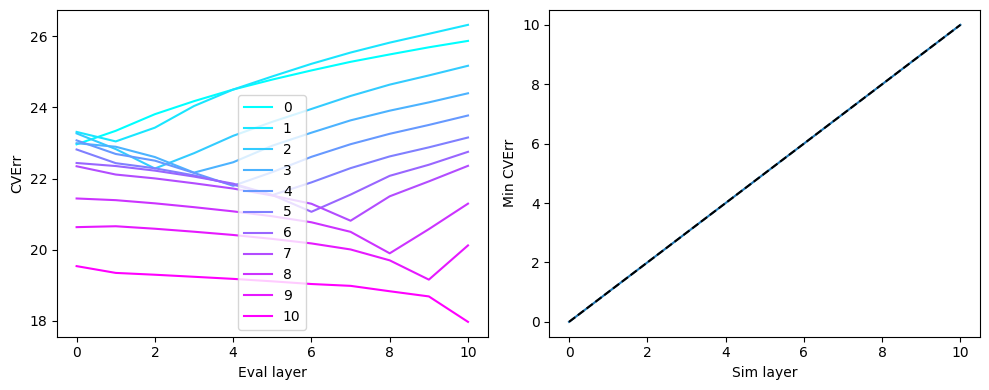

In [14]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the CV error of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerCvErr=all_layerCvErr[l,:]
    plt.plot(layerCvErr, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('CVErr')

# For each simulation, find which layer model had the lowest CV error
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerCvErr=all_layerCvErr[l,:]
    pk=np.argmin(layerCvErr)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Min CVErr')
plt.tight_layout()

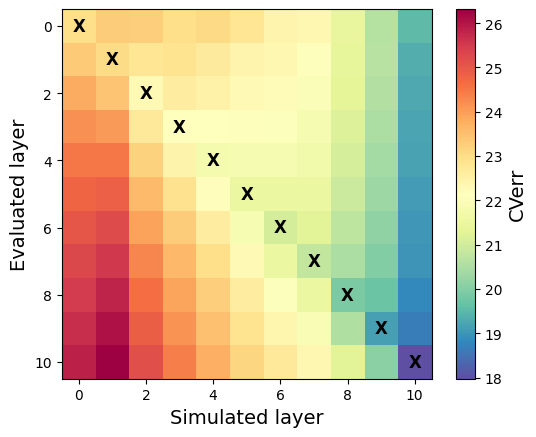

In [16]:
# Transpose for visualization
im=plt.imshow(all_layerCvErr.T, cmap='Spectral_r')

# Find the indices of the min value in each column
min_indices = np.argmin(all_layerCvErr, axis=1)

# Plot an 'X' at the center of the square for each column's minimum
for idx, min_idx in enumerate(min_indices):
    plt.text(idx, min_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

plt.xlabel('Simulated layer', fontsize=14)
plt.ylabel('Evaluated layer', fontsize=14)
cb=plt.colorbar(im)
cb.set_label('CVerr', fontsize=14)

In [17]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)